## Plot scaleogram from Morlet wavelet

In [ ]:
## Julia program to read a selected .HXV file and display 30-minute time series plots
## JW December 2022
#using ContinuousWavelets 
using CSV
using Dates, DataFrames, Distributions, DSP
##using Gtk
using LaTeXStrings
using NativeFileDialog
using Plots
using Printf
using Statistics #, StatsPlots
using Tk


function get_displacements(arry)
#####################################
    
    displacements = []

    if length(arry[1]) == 3
    
        for i in arry
            append!(displacements,parse(Int, SubString.(i, 1, 1), base=16)*16^2 + parse(Int, SubString.(i, 2, 2), base=16)*16^1 + parse(Int, SubString.(i, 3, 3), base=16)*16^0)
        end
        
    else
        
        for i in arry
            append!(displacements,parse(Int, SubString.(i, 1, 1), base=16)*16^1 + parse(Int, SubString.(i, 2, 2), base=16)*16^0)
        end
        
    end

    displacements[findall(>=(2048), displacements)] = 2048 .- displacements[findall(>=(2048), displacements)];
    
    return(displacements./100)
    
    end     # get_displacements()


function get_HNW(df)
#####################################
        
##    df = DataFrame(CSV.File(infil,header=0, delim=",", types=String));

    # Calculate sequence numbers
    arry = SubString.(df.Column1, 3, 4)

    global sequence = []

    for i in arry
        append!(sequence,parse(Int, SubString.(i, 1, 1), base=16)*16^1 + parse(Int, SubString.(i, 2, 2), base=16)*16^0)
    end

    # Calculate heave WSEs
    arry = SubString.(df.Column3, 1, 3);
    heave = get_displacements(arry);

    # Calculate north WSEs
    arry = SubString.(df.Column3, 4, ) .* SubString.(df.Column4, 1, 2)
    north = get_displacements(arry);

    # Calculate north WSEs
    arry = SubString.(df.Column4, 3, 4) .* SubString.(df.Column5, 1, 1)
    west = get_displacements(arry);

    return(heave, north, west)

    end    # get_HNW()


function calc_wse(df, wse_df, start_date)
#####################################    
    
    heave, north, west = get_HNW(df)
    
    # Identify any gaps in the recorded data
    tt = [0]
    append!(tt,diff(sequence))
    tt[tt.<0] .+= 256;
    tt1 = cumsum(tt);
    
    if length(tt1) > 2304
        tt1 = tt1[1:2304]
    end

    [wse_df[tt1[i]+1,2] = heave[i] for i in eachindex(tt1)];
    [wse_df[tt1[i]+1,3] = north[i] for i in eachindex(tt1)];
    [wse_df[tt1[i]+1,4] = west[i] for i in eachindex(tt1)];
    
    return(wse_df)
    
    end    # calc_wse()


function spike_value(wse)
#####################################
    
    median_value = median(wse)
    std_value = std(wse)

    return(median_value + 3*std_value)

    end    # spike_value()


function plot_wses(df, wse_df, is_gps)
#####################################
    
    spike = spike_value(wse_df.Heave)
    heave_spikes = findall(i->(i>=spike), abs.(wse_df.Heave));

    spike = spike_value(wse_df.North)
    north_spikes = findall(i->(i>=spike), abs.(wse_df.North));

    spike = spike_value(wse_df.West)
    west_spikes = findall(i->(i>=spike), abs.(wse_df.West));
    
    # create plots of heave, north, and west
    title_string = Dates.format(first(wse_df.Date), "dd/mm/yyyy HH:MM") # * " UTC"
    p1_hnw = scatter(wse_df[heave_spikes,:].Date, wse_df[heave_spikes,:].Heave, label="", ylabel="Heave", markershape=:circle, ms=4, mc=:white, ma=1, msc=:red, msa=0.25, msw=0.5)
    p1_hnw = plot!(wse_df.Date,wse_df.Heave, label="", c="#4a536b", lw=0.5, title=title_string, titlefontsize=12) ##last(split(infil,"\\")))

    # get plotting limits
    x_lim1 = xlims(p1_hnw)[1]; y_lim1 = ylims(p1_hnw)[1]
    x_lim2 = xlims(p1_hnw)[2]; y_lim2 = ylims(p1_hnw)[2]

    p2_hnw = scatter(wse_df[north_spikes,:].Date, wse_df[north_spikes,:].North, label="", ylabel="North", markershape=:circle, ms=4, mc=:white, ma=1, msc=:red, msa=0.25, msw=0.5)
    p2_hnw = plot!(wse_df.Date,wse_df.North, label="", c="#aed6dc", lw=0.5)
    p3_hnw = scatter(wse_df[west_spikes,:].Date,wse_df[west_spikes,:].West, label="", ylabel="West", markershape=:circle, ms=4, mc=:white, ma=1, msc=:red, msa=0.25, msw=0.5)
    p3_hnw = plot!(wse_df.Date,wse_df.West, label="", c="#ff9a8d", lw=0.5)

    hline!(p1_hnw, [0], lw=0.5, label="")
    hline!(p2_hnw, [0], lw=0.5, label="")
    hline!(p3_hnw, [0], lw=0.5, label="")
    
    if is_gps
        
        println("GPS buoy")
        flush(stdout)
        
        # Locate GPS errors
        global gps_errors = findall(isodd,parse.(Int,SubString.(string.(df.Column4), 2, 2), base = 16))

        if length(gps_errors) > 0
            vline!(p1_hnw, [wse_df.Date[1]], lw=0.5, ls=:dash, c=:red, label="GPS error")
            println(length(gps_errors)," GPS errors detected")
            flush(stdout)
        end

        for i in gps_errors
            vline!(p1_hnw, [wse_df.Date[i]], lw=0.5, ls=:dash, c=:red, label="")
        end
    
    end

    # get plotting limits
    x_lim1 = xlims(p1_hnw)[1]; y_lim1 = ylims(p1_hnw)[1]
    x_lim2 = xlims(p1_hnw)[2]; y_lim2 = ylims(p1_hnw)[2]

    # display plots to screen
    tm_tick = range(first(wse_df.Date),last(wse_df.Date),step=Minute(5))
    ticks = Dates.format.(tm_tick,"MM:SS")

    # display plots to screen
    plot_wse = Plots.plot(p1_hnw, p2_hnw, p3_hnw, layout = (3, 1), size = (1400, 600),
        xlim=(first(wse_df.Date),last(wse_df.Date)), xticks=(tm_tick,ticks), xtickfontsize=7,ytickfontsize=8,
        framestyle = :box,fg_legend=:transparent, legend=:bottomleft,
        leftmargin = 15Plots.mm, grid=true, gridlinewidth=0.5, gridstyle=:dot, gridalpha=1)            

    display(plot_wse)
    
    return()
    
    end    # plot_wses)


function do_fft(heave, N)
################################################
# calculate the Fourier coefficients vide (5.6.2)

    return([sum([heave[k]*exp(2*pi*-1im*k*l/N) for k in (1:N)]) for l in (1:N)])

    end    # do_fft()


function calc_psd(Hl, N)
################################################
# The power spectral density is obtained from the Fourier coefficients
    
    PSD = zeros(trunc(Int,N/2))

    for l = 1:trunc(Int,N/2)   
        if (l==1) || (l==trunc(Int,N/2)-1)
            PSD[l] = abs(Hl[l])^2
        else
            PSD[l] = abs(Hl[l])^2+abs(Hl[N-l-1])^2
        end
    end

    # Smooth coefficients vide (5.6.6)
    PSD_smooth = PSD
    [PSD_smooth[i] = PSD[i-1]/4 + PSD[i]/2 + PSD[i+1]/4 for i in (2:trunc(Int,N/2)-1)]

    return(PSD_smooth)

    end    # calc_psd()


function calc_tp5(f2,Sf)
##########################################
# Calculate Tp5 via Read method
    
    Sf_max = maximum(Sf)

    numerator = 0; denominator = 0

    Sf_sum = cumsum(Sf.*Sf_max).^5

    for i in eachindex(f2)
        w = Sf[i] / Sf_max
        numerator +=  f2[i] * w^5
        denominator += w^5
    end

    Fp5 = numerator / denominator
    
    return(Fp5)    # calc_tp5()

    end    # calc_tp5()


function calc_hm0(Sf,freq)
########################################## 
    
    ax1 = (last(freq) - first(freq)) / (length(freq)-1)

    # calc spectral moments m0, m1, m2, m3, and m4
    s00 = 0; m0 = 0

    for ii in 1:128

        s00 += freq[ii]^0 * Sf[ii];

    end

    m0 = 0.5*ax1*(first(freq)^0*first(Sf) + 2*s00 + last(freq)^0*last(Sf))

    return(4 * m0^0.5)

    end    # calc_hm0()


function calculate_frequency_domain_parameters(f2, spectra)
##########################################
# Calculate frequency-domain parameters    
# Calls: calc_tp5()
    
    ax1 = (last(f2) - first(f2)) / (length(f2)-1)

    # calc spectral moments m0, m1, m2, m3, and m4
    s00 = 0; s01 = 0; s02 = 0; s03 = 0; s04 = 0;
    m0 = 0; m1 = 0; m2 = 0; m3 = 0; m4 = 0

    for ii in 1:128

        s00 += f2[ii]^0 * spectra[ii]
        s01 += f2[ii]^1 * spectra[ii]
        s02 += f2[ii]^2 * spectra[ii]
        s03 += f2[ii]^3 * spectra[ii]
        s04 += f2[ii]^4 * spectra[ii]

    end

    m0 = 0.5*ax1*(first(f2)^0*first(spectra) + 2*s00 + last(f2)^0*last(spectra))
    m1 = 0.5*ax1*(first(f2)^1*first(spectra) + 2*s01 + last(f2)^1*last(spectra))
    m2 = 0.5*ax1*(first(f2)^2*first(spectra) + 2*s02 + last(f2)^2*last(spectra))
    m3 = 0.5*ax1*(first(f2)^3*first(spectra) + 2*s03 + last(f2)^3*last(spectra))
    m4 = 0.5*ax1*(first(f2)^4*first(spectra) + 2*s04 + last(f2)^4*last(spectra))

    ##println("m0 = ",m0," m1 = ",m1, " m2 = ",m2, " m3 = ",m2, " m4 = ",m4)

    # calc wave parameters Hm0, Hrms, T01, T02, Tc
    Hm0 = 4*sqrt(m0)     # Tucker & Pitt p.32 (2.2-6b)
    Hrms = sqrt(8*m0)    # Goda 2nd. Edition p.262 (9.15)
    T01 = m0/m1          # Tucker & Pitt p.41 Table 2.2 
    T02 = sqrt(m0/m2)    # Tucker & Pitt p.40 (2.3-2)
    Tc = sqrt(m2/m4)     # Tucker & Pitt p.41 Table 2.2 - also see Notes

    # identify spectral peak and frequency as peak
    Fp = f2[argmax(spectra)]
    Tp = 1/Fp
    fp5 = calc_tp5(f2, spectra)
    Tp5 = 1/fp5

    # calculate spectral width vide Tucker and Pitt p.85 (5.2-8)
    # Note: for JONSWAP, v = 0.39; for PM, v = 0.425
    v = (m0*m2 / m1^2 - 1)^0.5

    # calculate Skewness vide Tucker and Pitt p.109 (5.5-17)
    Skewness = (m0^2 * m3/m1^3 - 3*v^2 - 1) / v^3;
    
    return(Hm0, Hrms, T01, T02, Tc, Tp, fp5, Tp5, Skewness)
    
    end    # calculate_frequency_domain_parameters()


function calc_representative_spectra(frequency,Hm0,Tp,gamma)
##########################################    
    """
    function to calculate representative spectrum based on the Jonswap formula in Tucker and Pitt p.339 (10.3-9a)

    inputs:
        frequency - array of spectral frequencies
        Hm0 - floating point value
        Tp - floating point value
        gamma - floating point value - Peak ehhancement factor (Enter 1 for PM, or 3.3 for Jonswap)

        Typical calls:
        Spectra_PM = calc_representative_spectra(f2, Hm0, Tp, 1.0)
        Spectra_JONSWAP = calc_representative_spectra(f2, Hm0, Tp, 3.3)

    returns:
        Sf - array of representative spectra        
    """

    alpha = 1    # initial Philips constant (will decrease for each iteration required)
    g = 9.81
    fp = 1/Tp    # peak frequency

    hm0 = 99.    # set this to large value (so it will change on first iteration)

    Sf = [];

    while((Hm0 - hm0) <= 0.0005)

        Sf = vcat([alpha*g^2 * (2*pi)^-4 * ff^-5 * exp(-1.25 * (ff/fp)^-4) * gamma^exp(-(ff-fp)^2/(2*0.07^2 * fp^2)) for ff in frequency[findall(<=(fp), frequency)]],
                [alpha*g^2 * (2*pi)^-4 * ff^-5 * exp(-1.25 * (ff/fp)^-4) * gamma^exp(-(ff-fp)^2/(2*0.09^2 * fp^2)) for ff in frequency[findall(>(fp), frequency)]]);
        Sf[1] = 0;

###################################################################################################################################            
###  See discussion at https://stackoverflow.com/questions/44915116/how-to-decide-between-scipy-integrate-simps-or-numpy-trapz  ###
###################################################################################################################################

        ##        hm0 = 4*(np.trapz(Sf, frequency))^0.5    # calculate new Hm0 based on Sf values
        hm0 = calc_hm0(Sf,frequency);   # see https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.integrate.simps.html        
        alpha *= 0.95;    # reduce alpha by 5% so iterations approach a limit of 0.0005

    end

    return(Sf)
        
    end    # calc_representative_spectra()


function plot_spectra(wse_df)
################################################
    
    heave = wse_df.Heave
    Sample_frequency = 1.28
    
    # convert heave to matrix of individual 256-value spectra
    segments = Periodograms.arraysplit(heave, 512, 256)
    combined_segments = []
    
    for i in eachindex(segments)
        push!(combined_segments,power(periodogram(segments[i],nfft=512,fs=Sample_frequency,window=hanning)))
    end
    
    global freqs1 = freq(periodogram(segments[1],nfft=512,fs=Sample_frequency,window=hanning))
    global Pden = mean(combined_segments, dims = 1)

    # use Welch's method as a check
    global ps_w = welch_pgram(heave, 512, 256; onesided=true, nfft=512, fs=Sample_frequency, window=hanning);
    global f2 = freq(ps_w);
    global Pden2 = power(ps_w);


    Hm0, Hrms, T01, T02, Tc, Tp, fp5, Tp5, Skewness = calculate_frequency_domain_parameters(f2, Pden2)
    @printf("%s; Hm0 = %5.2fm; Hrms = %5.2fm; T01 = %5.2fs; T02 = %5.2fs; Tc = %5.2fs; Tp = %5.2fs; Tp5 = %5.2fs; Skewness = %5.4f",
        Dates.format(first(wse_df.Date), "yyyy-mm-dd HH:MM"),Hm0, Hrms, T01, T02, Tc, Tp, Tp5, Skewness)
    
    # Calculate representative spectra for P-M and JONSWAP
    Spectra_PM = calc_representative_spectra(f2, Hm0, Tp, 1.0);
    Spectra_JONSWAP = calc_representative_spectra(f2, Hm0, Tp, 3.3);

    # determing maximum y-axis value for spectral plots
    max_y = maximum([maximum(Pden[1]),maximum(Pden2),maximum(Spectra_JONSWAP)]) * 1.05
    
    if max_y < 0.1
        tick_val = 0.01
    elseif  max_y < 1
        tick_val = 0.1
    elseif max_y < 10
        tick_val = 1   
    else
        tick_val = 5
    end

    # Plot the representative spectra
    p_spectra = plot(f2,Spectra_JONSWAP, lw=2, c=:lightblue, label="JONSWAP spectrum (" * L"\gamma" * " = 3.3)")
    p_spectra = plot!(f2,Spectra_PM, lw=2, c=:lightgreen, label="Pierson-Moskowitz spectrum (" * L"\gamma" * " = 1.0)\n")
    
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@    
    # Add frequency-domain parameters to plot
    x_lim = xlims(p_spectra)[1]; y_lim = ylims(p_spectra)[2]
    p_spectra = annotate!(x_lim*-25, y_lim*0.65, "Hm0 = " * string(round(Hm0, digits=2)) * "m",annotationfontsize=10) 
    p_spectra = annotate!(x_lim*-25, y_lim*0.60, "Hrms = " * string(round(Hrms, digits=2)) * "m") 
    p_spectra = annotate!(x_lim*-25, y_lim*0.55, "T01 = " * string(round(T01, digits=2)) * "s") 
    p_spectra = annotate!(x_lim*-25, y_lim*0.50, "T02 = " * string(round(T02, digits=2)) * "s") 
    p_spectra = annotate!(x_lim*-25, y_lim*0.45, "Tp = " * string(round(Tp, digits=2)) * "s") 
    p_spectra = annotate!(x_lim*-25, y_lim*0.40, "Tp5 = " * string(round(Tp5, digits=2)) * "s") 
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@    
    
    
    # plot calculated spectra
    p_spectra = plot!(freqs1, Pden, label="Calc\n", 
        c=:yellow, lw=3, fillrange = 0, fillalpha = 0.05, fillcolor = :blue)
        
    # plot Welch's spectra
    p_spectra = plot!(f2, Pden2, label="Welch's method", 
        c=:red, lw=1, fillrange = 0, fillalpha = 0.05, fillcolor = :red)
    
    p_spectra = vline!([fp5; fp5], lw=1, ls =:dash, c=:red, label="Tp5")
    
    plot_spc = Plots.plot(p_spectra, layout = (1, 1), size = (1400, 600), framestyle = :box, 
        xlim=(0,0.64),  xticks = 0:0.05:1.28, xtickfontsize=7, ytickfontsize=8, xlabel="Frequency (Hertz)",
        ylim=(0,max_y), yticks=0:tick_val:max_y, ylabel="Spectral Density (sq.m/Hertz)",
        fg_legend=:transparent, title = " Spectral plot", titlefontsize=12,
        leftmargin = 15Plots.mm, bottommargin = 15Plots.mm, 
        grid=true, gridlinewidth=0.5, gridalpha=1, foreground_color_grid="lightgrey")            

    display(plot_spc)
    
    return()
    
    end    # plot_spectra()


function plot_spectrogram(wse_df)
    
    heave = wse_df.Heave;
    nw=256;
    spec = DSP.Periodograms.spectrogram(heave, nw, 250; fs=1.28,window=hanning);

    # display plots to screen
    tm_tick = range(first(wse_df.Date),last(wse_df.Date),step=Minute(5))
    ticks = Dates.format.(tm_tick,"MM:SS")

    spec1 = plot(first(wse_df.Date) + Microsecond.(ceil.((spec.time) * 1000000)), spec.freq, DSP.Periodograms.power(spec), lw=1, c=cgrad(:Spectral, rev=true), colorbar=false, 
        size=(1400, 600), framestyle = :box, title="Spectrogram", 
        xlim=(first(wse_df.Date),last(wse_df.Date)), xticks=(tm_tick,ticks), xtickfontsize=7, xlabel="Time (s)",
        ytickfontsize=8, ylabel="Frequency (Hz)",
        leftmargin = 15Plots.mm, bottommargin = 15Plots.mm, grid=true, gridlinewidth=0.5, gridstyle=:dot, gridalpha=1, show=true) 

    display(spec1)
    
    return()
    
    end    # plot_spectrogram()


function process_spectrum_file(df)
                                
    global is_gps = false
    sync_word_location = findall(x -> x == "7FFF", df.Column2)

    for j in sync_word_location

        i = df.Column2[j+1]
        word_number = parse(Int, SubString.(i, 1, 1), base=16)*16^0
        word = parse(Int, SubString.(i, 2, 2), base=16)*16^2 + parse(Int, SubString.(i, 3, 3), base=16)*16^1 + parse(Int, SubString.(i, 4, 4), base=16)*16^0
    #    println(j,' ',word_number,' ',word)

        # Test whether buoy is MkIII or DWR-G - see p.51 Table 5.7.5a. Organization and significance of the system file data 
        # If DWR-G:
        #     Av0 = 0; Ax0 = 0; Ay0 = 0; O = 0; and Inclination = 0
        
        if (word_number == 7 && word == 0)
            is_gps = true
        end

    end
    
    return(is_gps)
    
    end    # process_spectrum_file()


################################################
################################################
##           START OF MAIN PROGRAM
################################################
################################################

# Widen screen for better viewing
display("text/html", "<style>.container { width:100% !important; }</style>")

hxv_directory = pick_folder()

# build list of all hxv files in selected directory
hxv_files = filter(x->occursin(".hxv",x), readdir(hxv_directory));
hxv_files = hxv_files[findall(x->endswith(uppercase(x), ".HXV"), hxv_files)];

w = Toplevel("Select Date", 235, 400)
tcl("pack", "propagate", w, false)
f = Frame(w)
pack(f, expand=true, fill="both")

f1 = Frame(f)
lb = Treeview(f1, hxv_files)
scrollbars_add(f1, lb)
pack(f1,  expand=true, fill="both")

tcl("ttk::style", "configure", "TButton", foreground="blue", font="arial 16 bold")
b = Button(f, "Ok")
pack(b)

bind(b, "command") do path
    
    global file_choice = get_value(lb);
    
    # Select a HXV file
    global infil = hxv_directory * "\\" * file_choice[1]
    println("Selected ",infil)

    df = DataFrame(CSV.File(infil,header=0, delim=",", types=String));

#==
    # extract the datetime from the file name
    date_str = split(infil,".")[1]
    ll = length(date_str)
    start_date = DateTime.(date_str[ll-16:ll-1], "yyyy-mm-ddTHHhMMZ")
==#
    # Extract the date and time string and convert to DateTime object
    date_time_str = match(r"\d{4}-\d{2}-\d{2}T\d{2}h\d{2}", infil).match
    start_date = DateTime(date_time_str, "yyyy-mm-ddTHHhMM")
    
    # create df of 2304 rows, each 0.78s apart
    wse_df = DataFrame(Date = unix2datetime.(datetime2unix.(start_date) .+ (0:1/1.28:1800-1/1.28)), 
        Heave = zeros(2304), 
        North = zeros(2304), 
        West = zeros(2304));

    # populate the df based on sequence numbers
    global wse_df = calc_wse(df, wse_df, start_date)
    is_gps = process_spectrum_file(df)

    plot_wses(df, wse_df,is_gps)
#    plot_spectrogram(wse_df)
    plot_spectra(wse_df)

end

### Temporary test code for optimization - JW September 2024

In [ ]:
using DataFrames, CSV

function get_displacements(arry)
    #####################################
    
    n = length(arry[1])
    displacements = Vector{Int}(undef, length(arry))

    for (idx, i) in enumerate(arry)
        if n == 3
            displacements[idx] = parse(Int, SubString(i, 1, 1), base=16) * 16^2 +
                                 parse(Int, SubString(i, 2, 2), base=16) * 16^1 +
                                 parse(Int, SubString(i, 3, 3), base=16)
        else
            displacements[idx] = parse(Int, SubString(i, 1, 1), base=16) * 16^1 +
                                 parse(Int, SubString(i, 2, 2), base=16) * 16^0
        end
    end

    # Adjust displacements for values >= 2048
    idxs = findall(>=(2048), displacements)
    displacements[idxs] .= 2048 .- displacements[idxs]

    return(displacements ./ 100)
end  # get_displacements()

function get_HNW(infil)
    #####################################
        
    df = DataFrame(CSV.File(infil, header=0, delim=",", types=String))

    # Calculate sequence numbers
    arry = SubString.(df.Column1, 3, 4)
    sequence = [parse(Int, SubString(i, 1, 1), base=16) * 16^1 + parse(Int, SubString(i, 2, 2), base=16) for i in arry]

    # Calculate heave, north, and west WSEs
    heave = get_displacements(SubString.(df.Column3, 1, 3))
    north = get_displacements(SubString.(df.Column3, 4, ) .* SubString.(df.Column4, 1, 2))
    west = get_displacements(SubString.(df.Column4, 3, 4) .* SubString.(df.Column5, 1, 1))

    return heave, north, west, sequence
end  # get_HNW()


heave, north, west, sequence = get_HNW(infil)

# Identify any gaps in the recorded data
tt = [0]
append!(tt, diff(sequence))
tt[tt .< 0] .+= 256
tt1 = cumsum(tt)

# Limit to a maximum of 2304 entries
if length(tt1) > 2304
    tt1 = tt1[1:2304]
end

# Assign values to wse_df based on tt1
for i in eachindex(tt1)
    wse_df[tt1[i] + 1, 2] = heave[i]
    wse_df[tt1[i] + 1, 3] = north[i]
    wse_df[tt1[i] + 1, 4] = west[i]
end


### Improved version of extracting WSE's from df and handling gaps

In [ ]:
using DataFrames: DataFrame
using Dates: DateTime, unix2datetime
using DSP: welch_pgram, freq, power, hanning
using NativeFileDialog: pick_folder

##import DataFrames: Not, select!

# Function to convert frequency in Hertz to Period in Seconds
function convert_frequency_to_period(frequencies)
#################################################
    
return(1.0 ./ frequencies)
    
end    # convert_frequency_to_period()


################################################
################################################
################################################

rec_len = 2304
sample_frequency = 1.28 # sample frequency iMkIIIn Hertz
sample_length = 1800 # record length in seconds
sample_rate = Float64(1/sample_frequency) # sample spacing in seconds

global infil = hxv_directory * "\\" * file_choice[1]
    println("Selected ",infil)

date_str = split(infil,".")[1]
ll = length(date_str)
start_date = DateTime.(date_str[ll-16:ll-1], "yyyy-mm-ddTHHhMMZ")

# Create df of dates and NaN's
wse_df = DataFrame(
    Date = unix2datetime.(datetime2unix.(start_date) .+ (0:sample_rate:sample_length - sample_rate)), 
    Heave = fill(NaN, rec_len),
    North = fill(NaN, rec_len),
    West = fill(NaN, rec_len),  
    GPS_flag = fill(0, rec_len)  
)

# read HXV file to df
df = DataFrame(CSV.File(infil, header=0, delim=",", types=String))

# remove df rows where string length != 4
filter!(row -> all(length(row[i]) == 4 for i in 1:ncol(df)), df)
println(nrow(df)," rows available for processing")

# determine if buoy is DWR-G
is_gps = false

sync_word_location = findall(==("7FFF"), df.Column2)

if !isempty(sync_word_location)  # Proceed only if we found any "7FFF"
    next_row_data = df.Column2[sync_word_location .+ 1]
    word_numbers = parse.(Int, SubString.(next_row_data, 1, 1), base=16)
    words = parse.(Int, SubString.(next_row_data, 2, 4), base=16)
    
    if any((word_numbers .== 7) .& (words .== 0))
        is_gps = true
    end
    
end

is_gps ? println("GPS buoy") : println("MkIII buoy")   
    
hex_arr = SubString.(df.Column1, 3, 4)
arr = parse.(Int, hex_arr, base=16)
diffs = diff(arr)
diffs[diffs .< 0] .+= 256
cumulative_values = cumsum([1; diffs])
valid_indices = findall(<=(rec_len), cumulative_values)
valid_rows = cumulative_values[valid_indices]

# truncate number of rows if > rec_len
df = df[1:min(nrow(df), rec_len), :]

# Calculate heave, north, and west WSEs
wse_df[valid_rows, 2] .= get_displacements(SubString.(df.Column3, 1, 3))
north_hex = SubString.(df.Column3, 4, ) .* SubString.(df.Column4, 1, 2)
wse_df[valid_rows, 3] .= get_displacements(north_hex)
wse_df[valid_rows, 4] .= get_displacements(SubString.(df.Column4, 3, 4) .* SubString.(df.Column5, 1, 1))


# Function to check the LSB of a hexadecimal value
check_lsb(hex_str) = parse(Int, hex_str, base=16) & 1 == 1 ? 1 : 0

# Apply the function to each element in the array using map
wse_df[valid_rows, 5] = Int16.(map(check_lsb, north_hex))

ps_w = welch_pgram(wse_df.Heave, 256, 128; onesided=true, nfft=256, fs=sample_frequency, window=hanning)
f2 = freq(ps_w)
Pden2 = power(ps_w)

p1 = plot()

tm_tick = range(first(wse_df.Date),last(wse_df.Date),step=Minute(5))
ticks = Dates.format.(tm_tick,"MM:SS")

# Find indices of all values equal to 1 (represents Datawell GPS flag)
gps_flag = findall(==(1), wse_df.GPS_flag)

p1 = plot()

# show GPS errors
for jj in gps_flag
    p1 = vline!([wse_df.Date[jj]], lw=1, c=:red, label="")
end

# Plot the mean of the Noise Floor values
periods_sec = convert_frequency_to_period(f2)
# Create the two plots with specified sizes
p1 = plot!(wse_df.Date, wse_df.Heave, lc=:blue, lw=:0.5, ylabel="WSE (m)", label="", xlims=(wse_df.Date[1],wse_df.Date[end]), xticks=(tm_tick,ticks))
p2 = plot(f2, Pden2, lc=:blue, lw=:2, alpha=:0.75, fillrange=0, fillalpha=:0.125, label="", xlim=(0,0.64), ylim=(0,Inf),
        xlabel="Frequency (Hz)", ylabel="S(f) (m²/Hz)")
p3 = plot(plot(periods_sec, Pden2, lw=:2, label="", yaxis=:log, yminorticks=10, minorgrid=:true, xlabel= "Wave Period (s)", 
        ylabel="S(f) (m²/Hz)"), xlims=(0,200))

# Define the layout with varying sizes
l = @layout [a{0.5h}; b{0.5w} c{0.5w} [ Plots.grid(1,1) ] ]

title = Dates.format(first(wse_df.Date), "dd/mm/yyyy HH:MM")

# Combine the three plots
p1_p2_plot = plot(p1, p2, p3, framestyle = :box, leftmargin = 10Plots.mm, layout=l, suptitle=title, size=(1200, 800))

display(p1_p2_plot)

In [ ]:
using DataFrames, Statistics

# Function to identify runs of positive or negative values and their indices
function identify_runs_with_indices(data::Vector{Float64})
    runs = []
    current_run = []
    current_indices = []
    for i in 1:length(data)
        if isempty(current_run) || sign(data[i]) == sign(current_run[end])
            push!(current_run, data[i])
            push!(current_indices, i)
        else
            push!(runs, (current_run, current_indices))
            current_run = [data[i]]
            current_indices = [i]
        end
    end
    push!(runs, (current_run, current_indices))  # Add the last run
    return runs
end

# Identify runs in the Heave column
runs_with_indices = identify_runs_with_indices(wse_df.Heave)

# Analyze runs to find unusually long runs
threshold = 10  # Define a threshold for what you consider a long run
long_runs_with_indices = filter(run -> length(run[1]) > threshold, runs_with_indices)

# Print the indices and values of long runs
for (run, indices) in long_runs_with_indices
    println("Long run detected: Length = $(length(run)), Start Index = $(indices[1]), End Index = $(indices[end]), Values = $run")
end



In [ ]:
# Replace NaNs with the mean of the non-NaN values
wse_df.Heave = coalesce.(wse_df.Heave, mean(skipmissing(wse_df.Heave)))


### Development code

HTML{String}("<style>.jp-Cell { width: 120% !important; }</style>")

Reading Noise Floor data from C:\Users\Jim\Julia_programs\Datawell\RDT_vector\Data\Noise_floor.bin


""

Selected F:\hayp\2009-05-25\hayp_2009-05-25T00h00K.hxv
2304 rows available for processing
GPS buoy
6 GPS errors at 2009-05-25 00:00


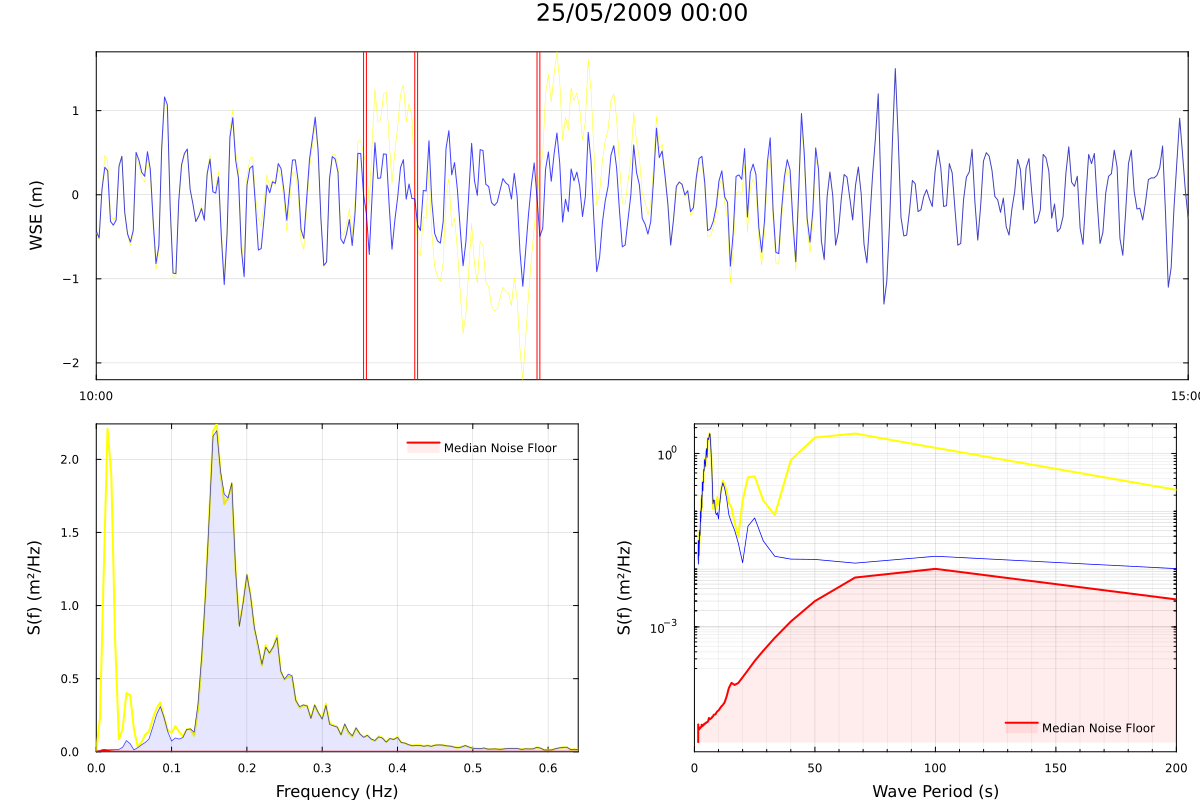

In [4]:
using Base.Filesystem: isfile
using CSV: CSV
using CurveFit: curve_fit
using DataFrames: DataFrame, ncol, nrow
using Dates: Dates, DateTime, unix2datetime, datetime2unix, Minute
using DSP: welch_pgram, freq, power, hanning
using NativeFileDialog: pick_folder
using Serialization: deserialize
using Statistics: median, var
using Tk: bind, Button, Frame, get_value, pack, scrollbars_add, tcl, Toplevel, Treeview
using Plots: Plots, plot, plot!, annotate!, vline!, @layout, text
using Polynomials: Polynomial

# Function to apply adaptive polynomial fit to WSE's affected by GPS errors
# Includes: adaptive polynomial degree, dynamic window size, and handling of closely spaced errors.
function fix_gps_errors(heave_bad, date, gps_flag)
    
    heave = deepcopy(heave_bad)
    gps_errors = findall(==(1), gps_flag)
    heave_length = length(heave)
    
    if !isempty(gps_errors)
        
        println(length(gps_errors), " GPS errors at ", Dates.format.(date, "yyyy-mm-dd HH:MM"))
        flush(stdout)

        # Combine adjacent GPS errors into groups
        grouped_errors = [gps_errors[1]]
        for i in 2:length(gps_errors)
            if gps_errors[i] - gps_errors[i-1] > 10  # e.g., if errors are > 10 points apart, treat them separately
                push!(grouped_errors, gps_errors[i])
            end
        end
        
        for ii in reverse(grouped_errors)
            error_center = ii

            if error_center <= 3
                error_center = 3
            end

            if error_center >= heave_length - 3
                error_center = heave_length - 3
            end

            # Dynamic window size based on wave variability (variance)
            # You can adjust this logic based on how variable the data is
            region_variability = var(heave[max(1, error_center-120):min(heave_length, error_center+120)])
            lower_offset = upper_offset = min(max(round(Int, 120 / sqrt(region_variability + 1)), 30), 120)

            if error_center <= lower_offset
                lower_offset = error_center - 1
            end

            if error_center + upper_offset > heave_length
                upper_offset = heave_length - error_center
            end

            lower_offset = max(lower_offset, 2)
            upper_offset = max(upper_offset, 2)

            left_side_points = max(1, error_center - lower_offset):error_center
            right_side_points = error_center:min(heave_length, error_center + upper_offset)

            # Adaptive polynomial fitting by testing different degrees
            best_fit_degree = 2
            min_rss = Inf
            for degree in 1:4  # Test degrees from 1 to 4
                fit1 = curve_fit(Polynomial, left_side_points, heave[left_side_points], degree)
                fit2 = curve_fit(Polynomial, right_side_points, heave[right_side_points], degree)
                rss = sum((heave[left_side_points] - fit1.(left_side_points)).^2) +
                      sum((heave[right_side_points] - fit2.(right_side_points)).^2)
                if rss < min_rss
                    min_rss = rss
                    best_fit_degree = degree
                end
            end

            # Perform the best fit using the selected degree
            fit1 = curve_fit(Polynomial, left_side_points, heave[left_side_points], best_fit_degree)
            yfit1 = fit1.(left_side_points)
            yfit1[end] = 0.0  # Set the last point of the left fit to 0

            fit2 = curve_fit(Polynomial, right_side_points, heave[right_side_points], best_fit_degree)
            yfit2 = fit2.(right_side_points)
            yfit2[1] = 0.0  # Set the first point of the right fit to 0

            # Apply polynomial results to WSEs on both sides of GPS error
            heave[left_side_points] .= heave[left_side_points] - yfit1
            heave[right_side_points] .= heave[right_side_points] - yfit2
            heave[ii] = 0.0  # Set WSE at GPS error location to 0
        end
    end

    return(heave)
    
end

# Function to apply polynomial fit to WSE's affected by GPS errors
# Uses selectable offset value to fine-tune result
function fix_gps_errorsxxx(heave_bad, date, gps_flag) 
##################################################
    
    heave = deepcopy(heave_bad)
    
    gps_errors = findall(==(1), gps_flag)
    heave_length = length(heave)
    
    if !isempty(gps_errors)
        
        println(length(gps_errors), " GPS errors at ", Dates.format.(date, "yyyy-mm-dd HH:MM"))
        flush(stdout)
        
        for ii in reverse(gps_errors)

            error_center = ii

            if error_center <= 3
                error_center = 3
            end

            if error_center >= heave_length - 3
                error_center = heave_length - 3
            end
            
            # User-selected offset either side of GPS error
            lower_offset = upper_offset = 120

            if error_center <= lower_offset
                lower_offset = error_center - 1
            end

            if error_center + upper_offset > heave_length
                upper_offset = heave_length - error_center
            end

            # Ensure there are at least 3 points for fitting
            lower_offset = max(lower_offset, 2)
            upper_offset = max(upper_offset, 2)
    
            # Handle edge cases
            left_side_points = max(1, error_center - lower_offset):error_center
            right_side_points = error_center:min(heave_length, error_center + upper_offset)

            # Fit curve to subset of heave before GPS error
            fit1 = curve_fit(Polynomial, left_side_points, heave[left_side_points], 2)
            yfit1 = fit1.(left_side_points)
            yfit1[end] = 0.0  # set the last point of the left fit to 0

            # Fit curve to subset of heave after GPS error
            fit2 = curve_fit(Polynomial, right_side_points, heave[right_side_points], 2)
            yfit2 = fit2.(right_side_points)
            yfit2[1] = 0.0  # set the first point of the right fit to 0

            # Apply polynomial results to WSEs on both sides of GPS error
            heave[left_side_points] .= heave[left_side_points] - yfit1
            heave[right_side_points] .= heave[right_side_points] - yfit2
            heave[ii] = 0.0  # set WSE at GPS error location to 0

        end
    
    end

    return(heave)
    
end  # fix_gps_errors()


function get_displacements(arry)
#####################################
    
    displacements = []

    if length(arry[1]) == 3
    
        for i in arry
            append!(displacements,parse(Int, SubString.(i, 1, 1), base=16)*16^2 
                + parse(Int, SubString.(i, 2, 2), base=16)*16^1 
                + parse(Int, SubString.(i, 3, 3), base=16)*16^0)
        end
        
    else
        
        for i in arry
            append!(displacements,parse(Int, SubString.(i, 1, 1), base=16)*16^1 
                + parse(Int, SubString.(i, 2, 2), base=16)*16^0)
        end
        
    end

    displacements[findall(>=(2048), displacements)] = 2048 .- displacements[findall(>=(2048), displacements)];
    
    return(displacements./100)
    
    end     # get_displacements()


# Function to convert frequency in Hertz to Period in Seconds
function convert_frequency_to_period(frequencies)
#################################################
    
return(1.0 ./ frequencies)
    
end    # convert_frequency_to_period()


using DataFrames
using Serialization

function read_noise_floor_file(file_path)
#########################################
    
    # Assuming the file contains a serialized DataFrame
    open(file_path, "r") do io
        return(deserialize(io))
    end
    
end

function get_noise_floor()
##########################
    
    paths = [
        "C:\\Users\\Jim\\Julia_programs\\Datawell\\RDT_vector\\Data\\Noise_floor.bin",
        "C:\\Users\\PC1\\Julia_programs\\Datawell\\RDT_vector\\Data\\Noise_floor.bin"
    ]
    
    noise_floor_file = nothing
    
    for path in paths
        if isfile(path)
            noise_floor_file = path
            break
        end
    end
    
    if isnothing(noise_floor_file)
        println("File not found in any of the provided paths. Exiting program.")
        flush(stdout)
        exit(1)
    end
    
    println("Reading Noise Floor data from ", noise_floor_file)
    
    # Deserialize the DataFrame from the file
    noise_floors_df = read_noise_floor_file(noise_floor_file)
    
    # Extract all spectral arrays from the DataFrame
    spectral_values = noise_floors_df.Pden2
    
    # Convert the list of arrays into a matrix where each row is a spectrum
    spectral_matrix = hcat(spectral_values...)'
    
    # Calculate the median spectra (median of each column)
    median_spectra = median(spectral_matrix, dims=1)
    
    # Convert the results to vectors
    median_spectra_vector = vec(median_spectra)

    return(median_spectra_vector)

end    # get_noise_floor() 


################################################
################################################
##           START OF MAIN PROGRAM
################################################
################################################

# Widen screen for better viewing
display(HTML("<style>.jp-Cell { width: 120% !important; }</style>"))

rec_len = 2304
sample_frequency = 1.28 # sample frequency in Hertz
sample_length = 1800 # record length in seconds
sample_rate = Float64(1/sample_frequency) # sample spacing in seconds

#using Logging: NullLogger, with_logger

# Widen screen for better viewing
display("text/html", "<style>.container { width:100% !important; }</style>")

global median_spectra_vector = get_noise_floor()

hxv_directory = pick_folder()

# build list of all hxv files in selected directory
hxv_files = filter(x->occursin(".hxv",x), readdir(hxv_directory));
hxv_files = hxv_files[findall(x->endswith(uppercase(x), ".HXV"), hxv_files)];

w = Toplevel("Select Date", 235, 800)
tcl("pack", "propagate", w, false)
f = Frame(w)
pack(f, expand=true, fill="both")

f1 = Frame(f)
lb = Treeview(f1, hxv_files)
scrollbars_add(f1, lb)
pack(f1,  expand=true, fill="both")

tcl("ttk::style", "configure", "TButton", foreground="blue", font="arial 16 bold")
b = Button(f, "Ok")
pack(b)

bind(b, "command") do path
    
    file_choice = get_value(lb);
    
    # Select a HXV file
    infil = hxv_directory * "\\" * file_choice[1]
    println("Selected ",infil)

    df = DataFrame(CSV.File(infil,header=0, delim=",", types=String));

    # extract the datetime from the file name
    date_str = split(infil,".")[1]
    ll = length(date_str)
    start_date = DateTime.(date_str[ll-16:ll-1], "yyyy-mm-ddTHHhMMZ")

    # Create df of dates and NaN's
    global wse_df = DataFrame(
        Date = unix2datetime.(datetime2unix.(start_date) .+ (0:sample_rate:sample_length - sample_rate)), 
        Heave = fill(NaN, rec_len),
        North = fill(NaN, rec_len),
        West = fill(NaN, rec_len),  
        GPS_flag = fill(0, rec_len)  
    )
    
    # read HXV file to df
    df = DataFrame(CSV.File(infil, header=0, delim=",", types=String))
    
    # remove df rows where string length != 4
    filter!(row -> all(length(row[i]) == 4 for i in 1:ncol(df)), df)
    println(nrow(df)," rows available for processing")
    
    # determine if buoy is DWR-G
    global is_gps = false
    
    sync_word_location = findall(==("7FFF"), df.Column2)
    
    if !isempty(sync_word_location)  # Proceed only if we've found any "7FFF"

        next_row_data = df.Column2[sync_word_location[findall(<(rec_len-1),sync_word_location)] .+ 1]
        word_numbers = parse.(Int, SubString.(next_row_data, 1, 1), base=16)
        words = parse.(Int, SubString.(next_row_data, 2, 4), base=16)

        if any((word_numbers .== 7) .& (words .== 0))
            is_gps = true
        end
        
    end
    
    hex_arr = SubString.(df.Column1, 3, 4)
    arr = parse.(Int, hex_arr, base=16)
    diffs = diff(arr)
    diffs[diffs .< 0] .+= 256
    cumulative_values = cumsum([1; diffs])
    valid_indices = findall(<=(rec_len), cumulative_values)
    valid_rows = cumulative_values[valid_indices]
    
    # truncate number of rows if > rec_len
    df = df[1:min(nrow(df), rec_len), :]
    
    # Calculate heave, north, and west WSEs
    wse_df[valid_rows, 2] .= get_displacements(SubString.(df.Column3, 1, 3))
    north_hex = SubString.(df.Column3, 4, ) .* SubString.(df.Column4, 1, 2)
    wse_df[valid_rows, 3] .= get_displacements(north_hex)
    wse_df[valid_rows, 4] .= get_displacements(SubString.(df.Column4, 3, 4) .* SubString.(df.Column5, 1, 1))
       
    # Function to check the LSB of a hexadecimal value
    check_lsb(hex_str) = parse(Int, hex_str, base=16) & 1 == 1 ? 1 : 0
    wse_df[valid_rows, 5] = Int16.(map(check_lsb, north_hex))

    global original_df = deepcopy(wse_df);

    # need to replace any NaN's with 0's in order to calculate spectra
    replace_nan(v) = map(x -> isnan(x) ? zero(x) : x, v)
    heave = map(replace_nan, wse_df.Heave)
    
    ps_w = welch_pgram(heave, 256, 128; onesided=true, nfft=256, fs=sample_frequency, window=hanning)
    f2 = freq(ps_w)
    Pden2 = power(ps_w)
    
    # convert frequency (Hz) to period (s)
    periods_sec = convert_frequency_to_period(f2)

    tm_tick = range(first(wse_df.Date),last(wse_df.Date),step=Minute(5))
    ticks = Dates.format.(tm_tick,"MM:SS")
    
    # Determine if GPS data should be fully plotted or only the first lines
    if is_gps
        
        println("GPS buoy")

        # Find indices of all values equal to 1 (represents Datawell GPS flag)
        gps_flag = findall(==(1), wse_df.GPS_flag)
        gps_errors_count = length(gps_flag)
           
        gps_errors_count > 0 ? error_string = string(length(gps_flag)," GPS errors flagged") : error_string = "No GPS errors flagged"
    
        fixed_heave = fix_gps_errors(heave, wse_df.Date[1],  wse_df.GPS_flag)
        ps_w1 = welch_pgram(fixed_heave, 256, 128; onesided=true, nfft=256, fs=sample_frequency, window=hanning)
        f2_fixed = freq(ps_w1)
        Pden2_fixed = power(ps_w1)
        
        # Plot for GPS buoy (all lines)
        p1 = plot(wse_df.Date, heave, lc=:yellow, lw=:0.5, ylabel="WSE (m)", label="", 
                  xlims=(wse_df.Date[1] + Minute(10),wse_df.Date[1] + Minute(15)), ylims=(minimum(wse_df.Heave), maximum(wse_df.Heave)), 
                  xticks=(tm_tick,ticks))
        
        # Show GPS errors identified by Datawell
        for jj in gps_flag
            p1 = vline!([wse_df.Date[jj]], lw=1, c=:red, label="")
        end
        
        p1 = plot!(wse_df.Date, fixed_heave, lc=:blue, lw=:1, alpha=:0.75, label="")
        p1 = annotate!(wse_df.Date[50], maximum(heave)*0.9, text(error_string, :left, 12))
        
        # p2 and p3 plots
        p2 = plot(f2, Pden2, lc=:yellow, lw=:2, alpha=:1, xlim=(0,0.64), ylim=(0,Inf), label="", xlabel="Frequency (Hz)", 
            ylabel="S(f) (m²/Hz)", fg_legend=:transparent, bg_legend=:transparent)
        p2 = plot!(f2_fixed, Pden2_fixed, lc=:blue, lw=:0.75, alpha=0.75, fillrange=0, fillcolor=:blue, fillalpha=0.1, label="")
        p2 = plot!(f2, median_spectra_vector, lw=:2, lc=:red, fillrange=0, fillalpha=0.075, fillcolor=:red, label="Median Noise Floor")
    
        p3 = plot(plot(periods_sec, Pden2, lc=:yellow, lw=:2, label="", yaxis=:log, yminorticks=10, minorgrid=:true, xlabel= "Wave Period (s)", 
            ylabel="S(f) (m²/Hz)"), xlims=(0,200), legend=:bottomright, fg_legend=:transparent, bg_legend=:transparent)
        p3 = plot!(periods_sec, Pden2_fixed, lc=:blue, lw=:0.75, label="")
        p3 = plot!(periods_sec, median_spectra_vector, lw=:2, lc=:red, fillrange=0.00001, fillalpha=0.075, fillcolor=:red, label="Median Noise Floor")
    
    else
        
        println("MkIII buoy")
    
        # Plot for MkIII buoy (first lines only)
        p1 = plot(wse_df.Date, heave, lc=:blue, lw=:0.5, ylabel="WSE (m)", label="", 
                  xlims=(wse_df.Date[1],wse_df.Date[end]), ylims=(minimum(heave), maximum(heave)), xticks=(tm_tick,ticks))
    
        # p2 and p3 plots - plot only first line of each
        p2 = plot(f2, Pden2, lc=:blue, lw=:2, alpha=1, fillrange=0, fillcolor=:blue, fillalpha=0.1, xlim=(0,0.64), 
            ylim=(0,Inf), label="", xlabel="Frequency (Hz)", ylabel="S(f) (m²/Hz)", fg_legend=:transparent, bg_legend=:transparent)
        p2 = vline!([1/30], lc=:red,lw=:2,ls=:dash,label="Datawell MkIII 30s cut-off")
    
        p3 = plot(periods_sec, Pden2, lc=:blue, lw=:2, minorgrid=:true, label="", xlabel="Wave Period (s)", 
            ylabel="S(f) (m²/Hz)", xlims=(0,50), fg_legend=:transparent, bg_legend=:transparent)
        p3 = vline!([30], lc=:red,lw=:2,ls=:dash,label="Datawell MkIII 30s cut-off")
    end

    # Combine the three plots as before
    l = @layout [a{0.5h}; b{0.5w} c{0.5w} [Plots.grid(1,1)]]
    title = Dates.format(first(wse_df.Date), "dd/mm/yyyy HH:MM")
    
    p1_p2__p3_plot = plot(p1, p2, p3, framestyle = :box, leftmargin = 10Plots.mm, layout=l, suptitle=title, size=(1200, 800))

    # Extract the date part from infil
    filename = split(infil, "\\") |> last
    date_part = split(filename, "T")[1]
    
    # Extract the time part from title and format it
    time_part = replace(split(title, " ")[2], ":" => "")
    
    # Combine the parts into the desired format
    output_filename = ".\\Plots\\" * date_part * "_" * time_part * ".png"
    
##    savefig(output_filename) 
    
    display(p1_p2__p3_plot)

end

### Investigate method of locating GPS error without flag

In [ ]:
using CurveFit: LogFit

x = Dates.datetime2julian.(wse_df.Date)
y = wse_df.Heave

fit1 = curve_fit(LogFit, x, y)
yfit1 = fit1.(x)

p1 = plot(wse_df.Date,wse_df.Heave, label="Original data")
p1 = plot!(wse_df.Date,yfit1, label = "Curve fit")

# Locate maximum run of negative values + 1 to identify center of GPS error
negatives = findall(x->x<0, wse_df.Heave)
neg_max = wse_df.Date[(negatives)[findmax(diff(negatives))[2]]+1]
p1 = vline!([neg_max],lw=:4,color=:yellow,z_order=:1,label=neg_max)

# display plots to screen
tm_tick = range(first(wse_df.Date), last(wse_df.Date), step=Minute(5))
ticks = Dates.format.(tm_tick,"MM:SS")

title = Dates.format(first(wse_df.Date), "dd/mm/yyyy HH:MM")
fix_gps = plot(p1,size = (1600, 600), title=title, titlefontsize=10, framestyle = :box, fg_legend=:transparent, bg_legend=:transparent, legend=:topright,
                xlim=(first(wse_df.Date),last(wse_df.Date)), bottommargin = 15Plots.mm, grid=true, gridlinewidth=0.5, gridstyle=:dot, gridalpha=1,xticks=(tm_tick,ticks))

display(fix_gps)


error_center = findfirst(x -> x == wse_df.Date[(negatives)[findmax(diff(negatives))[2]]+1], wse_df.Date)
ii = error_center
heave = deepcopy(wse_df.Heave)

# User-selected offset either side of GPS error
lower_offset = upper_offset = 50

if error_center <= lower_offset
    lower_offset = error_center - 1
end

if error_center+upper_offset > 2304
    upper_offset = 2304 - error_center
end

# Fit curve to subset of heave before GPS error
left_side_points = error_center-lower_offset:error_center
fit1 = curve_fit(Polynomial, left_side_points, heave[left_side_points], 2)
yfit1 = fit1.(left_side_points)
yfit1[length(yfit1)] = 0.0

# Fit curve to subset of heave after GPS error
right_side_points = error_center:error_center+upper_offset
fit2 = curve_fit(Polynomial, right_side_points, heave[right_side_points], 2)
yfit2 = fit2.(right_side_points)
yfit2[1] = 0.0

# apply polynomial results to wse's on both sides of GPS error
heave[left_side_points] .= heave[left_side_points] - yfit1
heave[right_side_points] .= heave[right_side_points] - yfit2
heave[ii] = 0.0    # set wse at GPS error location to 0

p2 = plot(wse_df.Date, wse_df.Heave, color=:yellow, label="Original data")
p2 = plot!(wse_df.Date, heave, color=:blue, label="Corrected data")

fixed_gps = plot(p2,size = (1600, 600), title=title, titlefontsize=10, framestyle = :box, fg_legend=:transparent, bg_legend=:transparent, legend=:topright,
                xlim=(first(wse_df.Date),last(wse_df.Date)), bottommargin = 15Plots.mm, grid=true, gridlinewidth=0.5, gridstyle=:dot, gridalpha=1,xticks=(tm_tick,ticks))

display(fixed_gps)

In [ ]:
using CurveFit: Polynomial

function find_runs_of_errors(heave_data, min_run_length)
    # Create a boolean array where true indicates a suspected error (based on heave being negative)
    suspected_errors = [x < 0 for x in heave_data]  # Detect negatives; adjust for positives if needed

    # Find all contiguous runs of true values (negative heave)
    runs_of_errors = []
    current_run = []

    for (i, is_error) in enumerate(suspected_errors)
        if is_error
            push!(current_run, i)
        else
            # If the current run is long enough, store it
            if length(current_run) >= min_run_length
                push!(runs_of_errors, current_run)
            end
            current_run = []  # Reset for the next run
        end
    end

    # Handle any run that ends at the last index
    if !isempty(current_run) && length(current_run) >= min_run_length
        push!(runs_of_errors, current_run)
    end

    return runs_of_errors  # This returns a list of index arrays, each representing a run of errors
end

function correct_small_runs!(heave, left_side_points, right_side_points)
    # Fallback logic for small runs (fewer than 4 points)
    if length(left_side_points) < 4
        # Fallback to linear fit for left side
        fit1 = curve_fit(Polynomial, left_side_points, heave[left_side_points], 1)
        yfit1 = fit1.(left_side_points)
    else
        # Standard quadratic fit for left side
        fit1 = curve_fit(Polynomial, left_side_points, heave[left_side_points], 2)
        yfit1 = fit1.(left_side_points)
    end
    yfit1[end] = 0.0  # Ensure the fit at the center is set to 0

    if length(right_side_points) < 4
        # Fallback to linear fit for right side
        fit2 = curve_fit(Polynomial, right_side_points, heave[right_side_points], 1)
        yfit2 = fit2.(right_side_points)
    else
        # Standard quadratic fit for right side
        fit2 = curve_fit(Polynomial, right_side_points, heave[right_side_points], 2)
        yfit2 = fit2.(right_side_points)
    end
    yfit2[1] = 0.0  # Ensure the fit starts at 0 on the right side

    # Apply the corrections
    heave[left_side_points] .= heave[left_side_points] - yfit1
    heave[right_side_points] .= heave[right_side_points] - yfit2
end

function get_run_centers(runs_of_errors)
    centers = []
    for run in runs_of_errors
        center_idx = run[div(length(run), 2) + 1]  # Take the middle of the run
        push!(centers, center_idx)
    end
    return centers
end

###################################################################
###################################################################
###################################################################

# Detect all runs of errors
min_run_length = 6
runs_of_errors = find_runs_of_errors(wse_df.Heave, min_run_length)

# Get the centers of the detected runs
error_centers = get_run_centers(runs_of_errors)

heave = deepcopy(wse_df.Heave)  # Work on a copy of the data

# Loop through each error center and apply the correction logic
for error_center in error_centers
    # Same offset logic as in fix_gps_errors_v_improved()
    lower_offset = upper_offset = 50  # You can adapt this dynamically

    # Adjust offsets if near the edges
    if error_center <= lower_offset
        lower_offset = error_center - 1
    end

    if error_center + upper_offset > length(heave)
        upper_offset = length(heave) - error_center
    end

    # Define left and right side points
    left_side_points = error_center - lower_offset:error_center
    right_side_points = error_center:error_center + upper_offset

    # Ensure both sides have sufficient points for fitting
    if length(left_side_points) >= 4 && length(right_side_points) >= 4
        # Perform polynomial fits as previously discussed
        fit1 = curve_fit(Polynomial, left_side_points, heave[left_side_points], 2)
        yfit1 = fit1.(left_side_points)
        yfit1[end] = 0.0  # Ensure the fit at the center is set to 0
        
        fit2 = curve_fit(Polynomial, right_side_points, heave[right_side_points], 2)
        yfit2 = fit2.(right_side_points)
        yfit2[1] = 0.0  # Ensure the fit starts at 0 on the right side
        
        # Apply the corrections
        heave[left_side_points] .= heave[left_side_points] - yfit1
        heave[right_side_points] .= heave[right_side_points] - yfit2
    else
        # Fall back to handling small runs if fewer than 4 points are available
        correct_small_runs!(heave, left_side_points, right_side_points)
    end

    # Set the center heave value to 0
    heave[error_center] = 0.0
end


In [ ]:
p1 = plot(wse_df.Date,wse_df.Heave, label="Original data")
#p1 = plot!(wse_df.Date,yfit1, label = "Curve fit")

p2 = plot(wse_df.Date, wse_df.Heave, color=:yellow, label="Original data")
p2 = plot!(wse_df.Date, heave, color=:blue, label="Corrected data")

fixed_gps = plot(p1, p2, layout=(2,1), size = (1600, 800), title=title, titlefontsize=10, framestyle = :box, fg_legend=:transparent, bg_legend=:transparent, legend=:topright,
                xlim=(first(wse_df.Date),last(wse_df.Date)), bottommargin = 15Plots.mm, grid=true, gridlinewidth=0.5, gridstyle=:dot, gridalpha=1,xticks=(tm_tick,ticks))

display(fixed_gps)

In [ ]:
wse_df = deepcopy(original_df)

using DataFrames, DSP
using SavitzkyGolay: savitzky_golay

function correct_gps_errors_with_savgol_reverse!(df::DataFrame)
###############################################################
    
    # Define the window size and polynomial order for the Savitzky-Golay filter
    default_window_size = 23
    polynomial_order = 3

    # Find GPS error indices
    gps_error_idxs = findall(df.GPS_flag .== 1)

    # Process GPS errors in reverse order
    for idx in reverse(gps_error_idxs)
        # Define the range to apply the filter (120 points before and after the GPS error)
        start_idx = max(1, idx - 150)
        end_idx = min(size(df, 1), idx + 150)
#==
        # Get the range of Heave values for smoothing
        heave_range = df.Heave[start_idx:end_idx]

        # Apply the Savitzky-Golay filter
        smoothed_heave = savitzky_golay(heave_range, window_size, polynomial_order).y

        # Vectorized operation: Update the Heave values, leaving GPS error point unchanged
        valid_idxs = setdiff(start_idx:end_idx, idx)  # Indices excluding the GPS error
        df.Heave[valid_idxs] .-= smoothed_heave[valid_idxs .- start_idx .+ 1]  # Apply corrections
    end
==#

        # Adjust window size dynamically if we are near the start or end
        actual_window_size = min(default_window_size, end_idx - start_idx + 1)

        # Handle cases near the start (insufficient data before the point)
        if idx <= actual_window_size ÷ 2
            # Use linear interpolation or just fill with a constant for the early points
            heave_range = df.Heave[start_idx:end_idx]
            smoothed_heave = fill(mean(heave_range), length(heave_range))  # Example: replace with mean
        else
            # Get the range of Heave values for smoothing
            heave_range = df.Heave[start_idx:end_idx]
            
            # Apply the Savitzky-Golay filter with the adjusted window size
            smoothed_heave = savitzky_golay(heave_range, actual_window_size, polynomial_order).y
        end

        # Vectorized operation: Update the Heave values, leaving GPS error point unchanged
        valid_idxs = setdiff(start_idx:end_idx, idx)  # Indices excluding the GPS error
        df.Heave[valid_idxs] .-= smoothed_heave[valid_idxs .- start_idx .+ 1]  # Apply corrections

    end
            
end    # correct_gps_errors_with_savgol_reverse!()


tm_tick = range(first(wse_df.Date),last(wse_df.Date),step=Minute(5))
ticks = Dates.format.(tm_tick,"MM:SS")

p1 = plot(size=(1200, 600), lw=:1, xlims=(wse_df.Date[1] + Minute(0),wse_df.Date[1] + Minute(30)), ylabel="WSE (m)", #ylims=(minimum(heave), maximum(heave)), 
          xticks=(tm_tick,ticks), leftmargin = 10Plots.mm, framestyle = :box)

# Plot for GPS buoy (all lines)
#p1 = plot!(wse_df.Date, wse_df.Heave, lc=:yellow, lw=:1, label="Original")

##==
# Show GPS errors identified by Datawell
gps_flag = findall(==(1), wse_df.GPS_flag)
for jj in gps_flag
    p1 = vline!([wse_df.Date[jj]], lw=1, c=:red, label="")
end
#==#

correct_gps_errors_with_savgol_reverse!(wse_df)


p1 = plot!(wse_df.Date, wse_df.Heave, lc=:blue, lw=:0.5, alpha=:0.5, label="Corrected")

display(p1)

In [ ]:
using DataFrames, DSP

function correct_gps_errors_with_savgol_reverse!(df::DataFrame, window_size::Int, polynomial_order::Int)
    # Create an array to store the fitted values (smoothed curve)
    fit_vals = similar(df.Heave, Float64)
    fill!(fit_vals, NaN)  # Initialize with NaN values

    gps_error_idxs = findall(df.GPS_flag .== 1)

    # Process from the end of the array to the start
    for idx in reverse(gps_error_idxs)
        # Define the range to fit the curve (120 points before and after)
        start_idx = max(1, idx - 120)
        end_idx = min(size(df, 1), idx + 120)

        # Get the data to fit the curve (this will include the GPS error itself)
        range_df = df[start_idx:end_idx, :]

        # Apply the Savitzky-Golay filter to the Heave values in this range
        smoothed_heave = savitzky_golay(range_df.Heave, window_size, polynomial_order).y  # Correct usage

        # Store the smoothed values in fit_vals
        for i in start_idx:end_idx
            fit_vals[i] = smoothed_heave[i - start_idx + 1]  # Store smoothed value
        end
    end

    # Adjust Heave values by subtracting the fitted values (smoothed)
    for idx in reverse(gps_error_idxs)
        start_idx = max(1, idx - 120)
        end_idx = min(size(df, 1), idx + 120)
        
        for i in start_idx:end_idx
            if i != idx  # Do not adjust the NaN point (the GPS error itself)
                df.Heave[i] -= fit_vals[i]  # Subtract the fitted value
            end
        end
    end

    return fit_vals  # Return the fitted values (smoothed curve)
end

# Usage:
# wse_df is the DataFrame containing the :Date, :Heave, :GPS_flag columns.
window_size = 23  # Adjust as necessary
polynomial_order = 3  # Adjust as necessary

adjusted_fit = correct_gps_errors_with_savgol_reverse!(wse_df, window_size, polynomial_order)

# Now `adjusted_fit` should contain the Savitzky-Golay smoothed values for the affected regions.


In [ ]:
using CSV, DataFrames

# Assuming wse_df is your DataFrame
CSV.write(".\\wse.csv", wse_df)

In [ ]:
using Interpolations
using SavitzkyGolay: savitzky_golay
using Statistics: mean

# Sample data (replace with your actual data)
Date = wse_df.Date
Heave = wse_df.Heave
GPS_flag = wse_df.GPS_flag


function correct_gps_errors!(df::DataFrame)
    for row in eachrow(df)
        if row.GPS_flag == 1
            row.Heave = NaN  # Mark GPS errors with NaN
        end
    end
end

function fit_curve_with_savgol(df::DataFrame, window_size::Int, poly_order::Int)
    # Correct GPS errors
    correct_gps_errors!(df)
    
    # Remove NaN values (if any)
    df = dropmissing(df, :Heave)

    # Savitzky-Golay smoothing
    smoothed_heave = savitzky_golay(df.Heave, window_size, poly_order)
    
    return smoothed_heave
end

# Applying the Savitzky-Golay filter
window_size = 31  # You can adjust this
poly_order = 3  # Typically 2 or 3
fitted_heave = fit_curve_with_savgol(wse_df, window_size, poly_order)

tm_tick = range(first(wse_df.Date),last(wse_df.Date),step=Minute(5))
ticks = Dates.format.(tm_tick,"MM:SS")

mean_val = mean(filter(!isnan, wse_df.Heave))

# Plot for GPS buoy (all lines)
p1 = plot(wse_df.Date, wse_df.Heave, lc=:yellow, lw=:3, ylabel="WSE (m)", label="", 
          xlims=(wse_df.Date[1] + Minute(0),wse_df.Date[1] + Minute(30)), ylims=(minimum(wse_df.Heave), maximum(wse_df.Heave)), 
          xticks=(tm_tick,ticks), size=(1200, 600), framestyle=:box)

p1 = plot!(wse_df.Date, wse_df.Heave-fitted_heave.y .+ mean_val, lc=:blue, label="")

display(p1)

### save noise floor to file

In [ ]:
paths = [
        "C:\\Users\\Jim\\Julia_programs\\Datawell\\RDT_vector\\Data\\Noise_floor.bin",
        "C:\\Users\\PC1\\Julia_programs\\Datawell\\RDT_vector\\Data\\Noise_floor.bin"
    ]

noise_floor_file = nothing

for path in paths
    if isfile(path)
        noise_floor_file = path
        break
    end
end

if isnothing(noise_floor_file)
    println("File not found in any of the provided paths. Exiting program.")
    flush(stdout)
    exit(1)
end

println("Reading Noise Floor data from ", noise_floor_file)

# Deserialize the DataFrame from the file
noise_floors_df = read_noise_floor_file(noise_floor_file)

# Extract all spectral arrays from the DataFrame
spectral_values = noise_floors_df.Pden2

# Convert the list of arrays into a matrix where each row is a spectrum
spectral_matrix = hcat(spectral_values...)'

In [ ]:
noise_floors_df

In [ ]:
p1 = plot(size=(1000,1000), xaxis=:log, yaxis=:log, xlims=(1e-3,1e0), ylims=(1e-6,1e0),
    fg_legend=:false, bg_legend=:transparent, framestyle=:box)

f2 = noise_floors_df.f2[1]
f2[1] = 0.001

for i in 1:size(spectral_matrix, 1)

    p1 = plot!(f2, spectral_matrix[i,:], label="")

end

p1 = plot!(f2, mean(spectral_matrix, dims=1)[1,:], lw=:2, lc=:blue, label="Mean")
p1 = plot!(f2, median(spectral_matrix, dims=1)[1,:], lw=:2, lc=:red, label="Median")

display(p1)

In [ ]:
using DataFrames

# Function to identify runs of all-positive or all-negative Heave values
function detect_runs_of_errors(df::DataFrame; run_threshold)
    # Create a new column for marking detected error runs
    df.Error_Run = falses(size(df, 1))
    
    # Track the start and length of runs of all-positive or all-negative values
    run_start = nothing
    run_sign = 0
    run_length = 0
    
    for i in 1:size(df, 1)
        current_heave = df.Heave[i]
        
        # Determine the sign of the current Heave value
        current_sign = sign(current_heave)
        
        if current_sign != 0 && (run_sign == 0 || current_sign == run_sign)
            # Continue the run
            run_length += 1
            run_sign = current_sign
            if isnothing(run_start)
                run_start = i
            end
        else
            # Check if the run exceeds the threshold, if so mark as error
            if run_length >= run_threshold && !isnothing(run_start)
                df.Error_Run[run_start:i-1] .= true
            end
            # Reset for a new run
            run_start = nothing
            run_length = 0
            run_sign = current_sign != 0 ? current_sign : 0
            run_start = current_sign != 0 ? i : nothing
            run_length = current_sign != 0 ? 1 : 0
        end
    end
    
    # Final check at the end of the loop
    if run_length >= run_threshold && !isnothing(run_start)
        df.Error_Run[run_start:end] .= true
    end

    return df
end

# Example usage (adjust `run_threshold` to change the minimum length of a run):
wse_df = detect_runs_of_errors(wse_df, run_threshold=10)


In [ ]:
using DataFrames

# Function to detect runs of all-positive or all-negative Heave values with tolerance for sign changes
function detect_runs_with_tolerance(df::DataFrame; run_threshold::Int=3, tolerance::Int=1)
    # Create a new column to mark detected error runs
    df.Error_Run = falses(size(df, 1))
    
    # Variables to track the start, length, and sign changes in a run
    run_start = nothing
    run_sign = 0
    run_length = 0
    sign_changes = 0
    
    for i in 1:size(df, 1)
        current_heave = df.Heave[i]
        current_sign = sign(current_heave)
        
        if current_sign != 0
            if run_sign == 0 || current_sign == run_sign
                # Continue the run
                run_length += 1
                if isnothing(run_start)
                    run_start = i
                end
            else
                # Allow for tolerated sign changes
                if sign_changes < tolerance
                    sign_changes += 1
                    run_length += 1
                else
                    # If tolerance is exceeded, finalize the run and reset
                    if run_length >= run_threshold && !isnothing(run_start)
                        df.Error_Run[run_start:i-1] .= true
                    end
                    # Reset for a new run
                    run_start = i
                    run_sign = current_sign
                    run_length = 1
                    sign_changes = 0
                end
            end
            run_sign = current_sign
        else
            # Treat zero values as valid points (continue run without changing sign)
            if run_sign != 0
                run_length += 1
            end
        end
    end
    
    # Final check at the end of the loop
    if run_length >= run_threshold && !isnothing(run_start)
        df.Error_Run[run_start:end] .= true
    end

    return df
end

# Example usage (adjust `run_threshold` for minimum run length, and `tolerance` for allowed sign changes):
wse_df = detect_runs_with_tolerance(wse_df, run_threshold=7, tolerance=3)


### Set start time for plots that follow

In [ ]:
first_time = wse_df.Date[1] #DateTime(2009,05,25,0,30)

In [ ]:
using Plots: scatter!
using Statistics: mean, cumsum

function moving_average(data, window_size)
    return [mean(data[max(1, i-window_size):min(end, i+window_size)]) for i in 1:length(data)]
end

first_time = first_time #DateTime(2009,05,25,0,10)
last_time = first_time + Minute(10)
suspect = findall(==(true), wse_df.Error_Run)
plot(wse_df.Date, wse_df.Heave, lc=:yellow, lw=:2, size=(1200,600), xlims=(first_time,last_time), title="", fg_legend=:transparent, bg_legend=:transparent, framestyle = :box)
#scatter!(wse_df.Date[suspect], wse_df.Heave[suspect])

using SavitzkyGolay: savitzky_golay

window_size = 23
polynomial_order = 3

# Apply Savitzky-Golay filter
sg = savitzky_golay(wse_df.Heave, window_size, polynomial_order)

sg_mean = mean(wse_df.Heave .- sg.y)

sg_heave = wse_df.Heave .- sg.y
#plot!(wse_df.Date,  sg_heave, lw=:1, lc=:blue, label="SG Filtered")

width = 10

ma_filtered = moving_average(wse_df.Heave, width)
plot!(wse_df.Date,  ma_filtered, lw=:2, lc=:red, ls=:dot, alpha=:0.5, label="\nSG Filter")
#plot!(wse_df.Date[suspect],ma_filtered[suspect])
plot!(wse_df.Date,  wse_df.Heave .- ma_filtered, lw=:1, lc=:blue, label="\nSG Filtered")

### Locate deviation of running mean from zero line

In [ ]:
using DataFrames, Statistics

# Function to compute a running mean
function running_mean(data::Vector{T}, window_size::Int) where T
################################################################
    
    cumulative_sum = [0; cumsum(data)]  # Compute cumulative sum
    mean_vals = (cumulative_sum[window_size+1:end] .- cumulative_sum[1:end-window_size]) ./ window_size
    
    return vcat(fill(mean(data[1:window_size]), window_size-1), mean_vals)  # Prepend means for start points

end    # running_mean()


# Function to detect runs of all-positive or all-negative values using the running mean
function detect_runs_with_running_mean(df::DataFrame; run_threshold::Int=3, window_size::Int=5, tolerance::Int=1)
    #############################################################################################################
    
    # Compute the running mean for the Heave column
    running_mean_heave = running_mean(df.Heave, window_size)
    
    # Create a new column to mark detected error runs
    df.Error_Run = falses(size(df, 1))
    
    # Variables to track the start, length, and sign changes in a run
    run_start = nothing
    run_sign = 0
    run_length = 0
    sign_changes = 0
    
    for i in 1:size(df, 1)
        current_heave = running_mean_heave[i]
        current_sign = sign(current_heave)
        
        if current_sign != 0
            if run_sign == 0 || current_sign == run_sign
                # Continue the run
                run_length += 1
                if isnothing(run_start)
                    run_start = i
                end
            else
                # Allow for tolerated sign changes
                if sign_changes < tolerance
                    sign_changes += 1
                    run_length += 1
                else
                    # If tolerance is exceeded, finalize the run and reset
                    if run_length >= run_threshold && !isnothing(run_start)
                        df.Error_Run[run_start:i-1] .= true
                    end
                    # Reset for a new run
                    run_start = i
                    run_sign = current_sign
                    run_length = 1
                    sign_changes = 0
                end
            end
            run_sign = current_sign
        else
            # Treat zero values as valid points (continue run without changing sign)
            if run_sign != 0
                run_length += 1
            end
        end
    end
    
    # Final check at the end of the loop
    if run_length >= run_threshold && !isnothing(run_start)
        df.Error_Run[run_start:end] .= true
    end

    return(df)
    
end    # detect_runs_with_running_mean()


#########################################################################################
#########################################################################################
#########################################################################################

first_time = first_time #DateTime(2009,05,10,0,00)
last_time = first_time + Minute(10)

#==
Given data sampling rate of 1.28 Hz and the GPS error span of ~ 3 minutes:

1. Window Size for Running Mean (window_size): 1.28 Hz means there are 1.28 data points per second.
    In 3 minutes (180 seconds), you will have approximately: 1.28 × 180 ≈ 230 data points
    Set the window_size to cover a smaller period, such as 10–20 seconds, to smooth the data effectively. 
    
    This would correspond to: Window Size≈1.28×10=12.8to1.28×20=25.6
    So, a reasonable starting point for the running mean window size might be 15 to 25 data points.

2. Run Threshold (run_threshold):
    Since a GPS error can span up to 3 minutes, this corresponds to about 230 data points.
    The run_threshold should capture a significant part of this error. 
    Might not want to set it to the full 230 points but a smaller fraction, such as 20% of the full span:
    Run Threshold ≈ 0.2 × 230 = 46
    Start by setting the run_threshold to 40–50 data points.

3. Tolerance (tolerance):
    Tolerance allows for minor sign changes within a run. Since GPS errors can span 3 minutes (about 230 points), allow a few sign changes, but not too many.
    Setting a tolerance of 1 to 2 sign changes should be reasonable, as this allows for very minor fluctuations while keeping the overall run detection robust.
==#

window_size = 25  # Adjust window size for the running mean
run_threshold = 45  # Minimum run length
tolerance = 2  # Allowed number of sign changes

wse_df = detect_runs_with_running_mean(wse_df, run_threshold=run_threshold, window_size=window_size, tolerance=tolerance)

suspect = findall(==(true), wse_df.Error_Run)

title="Locate deviation of running mean from zero"

plot(wse_df.Date, wse_df.Heave, lc=:yellow, lw=:2, label="Original Heave", size=(1200,600), 
    xlims=(first_time,last_time), title=title, fg_legend=:transparent, bg_legend=:transparent, framestyle = :box)
scatter!(wse_df.Date[suspect], wse_df.Heave[suspect], marker=:x, ms=:2, label="Suspects")

function moving_average(data, window_size)
    return [mean(data[max(1, i-window_size):min(end, i+window_size)]) for i in 1:length(data)]
end
width = 25
ma_filtered = moving_average(wse_df.Heave[suspect], width)
plot!(wse_df.Date[suspect],  ma_filtered, lw=:2, lc=:red, ls=:dot, alpha=:0.5, label="Moving average filter")
plot!(wse_df.Date[suspect],  wse_df.Heave[suspect] .- ma_filtered, lw=:1, lc=:blue, label="Filtered")


### Revisit SavitzkyGolay

In [ ]:
# set initial time for closer inspection
first_time = first_time #DateTime(2009,05,10,0,00)
last_time = first_time + Minute(10)

subset = findall(first_time.<= wse_df.Date .< last_time);

using SavitzkyGolay: savitzky_golay
using Plots: plot

window_size = 23
polynomial_order = 3

# Apply Savitzky-Golay filter
sg = savitzky_golay(wse_df.Heave, window_size, polynomial_order)

title="SavitzkyGolay "*string(window_size)

plot(wse_df.Date, wse_df.Heave, label="", lw=:1, lc=:yellow, size=(1200,600), xlims=(first_time, last_time), 
    title=title, fg_legend=:transparent, bg_legend=:transparent, framestyle = :box)

if is_gps   
    # Find indices of all values equal to 1 (represents Datawell GPS flag)
    gps_flag = findall(==(1), wse_df.GPS_flag)
    # Show GPS errors identified by Datawell
    for jj in gps_flag
        vline!([wse_df.Date[jj]], lw=1, c=:red, label="")
    end
    annotate!(first_time, maximum(wse_df.Heave[subset])*0.9, text(string(length(gps_flag)," GPS errors flagged"), :left, 12))
end

sg_heave = wse_df.Heave .- sg.y
plot!(wse_df.Date,  sg_heave, lw=:1, lc=:blue, label="SG Filtered")
plot!(wse_df.Date,  sg.y, label="Filter", lw=:2, lc=:red, ls=:dot, alpha=:0.5)
using Plots: hline!

mean_line = mean(wse_df.Heave .- sg.y)
hline!([mean_line],lc=:green, label="M.W.L.")

### Using SavitzkyGolay

In [ ]:
using SavitzkyGolay: savitzky_golay
using Plots: plot, hline!

window_size = 23
polynomial_order = 3

# Apply Savitzky-Golay filter
sg = savitzky_golay(wse_df.Heave, window_size, polynomial_order)
title = Dates.format(first_time, "yyyy-mm-dd HH:MM") * " SavitzkyGolay "*string(window_size)

p1 = plot(wse_df.Date, wse_df.Heave, lc=:yellow, lw=:2, label="", size=(1200,600), xlims=(first_time, last_time), 
    title=title, fg_legend=:transparent, bg_legend=:transparent, framestyle = :box)

if is_gps   
    # Find indices of all values equal to 1 (represents Datawell GPS flag)
    gps_flag = findall(==(1), wse_df.GPS_flag)
    # Show GPS errors identified by Datawell
    for jj in gps_flag
        vline!([wse_df.Date[jj]], lw=1, c=:red, label="")
    end
    annotate!(first_time, maximum(wse_df.Heave[subset])*0.9, text("  "*string(length(gps_flag)," GPS errors flagged"), :left, 12))
end

p1 = plot!(wse_df.Date,  sg.y, label="\nFilter", lw=:2, lc=:red, ls=:dot, alpha=:0.5)
p1 = plot!(wse_df.Date, sg_heave, lc=:blue, lw=:1, label="\nMa Filtered")

mean_line = mean(fixed_heave)
p1 = hline!([mean_line],lc=:green, label="M.W.L.")

display(p1)

ps_w = welch_pgram(wse_df.Heave, 256, 128; onesided=true, nfft=256, fs=sample_frequency, window=hanning)
f2 = freq(ps_w)
Pden2 = power(ps_w)

ps_w = welch_pgram(fixed_heave, 256, 128; onesided=true, nfft=256, fs=sample_frequency, window=hanning)
fixed_f2 = freq(ps_w)
fixed_Pden2 = power(ps_w)

ps_w = welch_pgram(sg_heave, 256, 128; onesided=true, nfft=256, fs=sample_frequency, window=hanning)
sg_f2 = freq(ps_w)
sg_Pden2 = power(ps_w)

p2 = plot(f2, Pden2, lc=:grey, lw=:0.5, alpha=1, label="Orig.", fillrange=0, fillcolor=:yellow, fillalpha=0.1, xlim=(0,0.64), title=title,
    ylim=(0,Inf), xlabel="Frequency (Hz)", ylabel="S(f) (m²/Hz)", fg_legend=:transparent, bg_legend=:transparent, size=(800,800), framestyle = :box)

#p2 = plot!(fixed_f2, fixed_Pden2, lc=:blue, lw=:2, alpha=1, label="JW Filter")

p2 = plot!(sg_f2, sg_Pden2, lc=:red, lw=:1, alpha=1, label="\nSg Filter\n")

p2 = plot!(f2, median_spectra_vector, lw=:2, lc=:red, fillrange=0, fillalpha=0.075, fillcolor=:red, label="\nMedian Noise Floor")

display(p2)

### Using Moving Average

In [ ]:
using Statistics: median, mean

function moving_average(data, window_size)
    return [mean(data[max(1, i-window_size):min(end, i+window_size)]) for i in 1:length(data)]
end

width = 11

ma_filtered = moving_average(wse_df.Heave, width)
ma_heave = wse_df.Heave .- ma_filtered

title = Dates.format(first_time, "yyyy-mm-dd HH:MM") * " Moving average "*string(width)

p1 = plot(wse_df.Date, wse_df.Heave, label="", lw=:2, lc=:yellow, size=(1200,600), xlims=(first_time, last_time), 
    title=title, fg_legend=:transparent, bg_legend=:transparent, framestyle = :box)
p1 = plot!(wse_df.Date,  ma_filtered, label="\nMa Filter", lw=:2, lc=:red, ls=:dot, alpha=:0.5)
p1 = plot!(wse_df.Date,  ma_heave, lw=:1, lc=:blue, label="\nMa Filtered")

mean_line = median(ma_heave)
p1 = hline!([mean_line],lc=:green, label="M.W.L.")

display(p1)

ps_w = welch_pgram(wse_df.Heave, 256, 128; onesided=true, nfft=256, fs=sample_frequency, window=hanning)
f2 = freq(ps_w)
Pden2 = power(ps_w)

ps_w = welch_pgram(ma_heave, 256, 128; onesided=true, nfft=256, fs=sample_frequency, window=hanning)
ma_f2 = freq(ps_w)
ma_Pden2 = power(ps_w)

p2 = plot(f2, Pden2, lc=:grey, lw=:0.5, alpha=1, label="Orig.", fillrange=0, fillcolor=:yellow, fillalpha=0.1, xlim=(0,0.64), title=title,
    ylim=(0,Inf), xlabel="Frequency (Hz)", ylabel="S(f) (m²/Hz)", fg_legend=:transparent, bg_legend=:transparent, size=(800,800), framestyle = :box)

#p2 = plot!(fixed_f2, fixed_Pden2, lc=:blue, lw=:2, alpha=1, label="JW Filter")

p2 = plot!(ma_f2, ma_Pden2, lc=:red, lw=:1, alpha=1, label="\nMa Filter\n")
p2 = plot!(f2, median_spectra_vector, lw=:2, lc=:red, fillrange=0, fillalpha=0.075, fillcolor=:red, label="\nMedian Noise Floor")

display(p2)

### Using FastRunningMedian() function

In [ ]:
using FastRunningMedian: running_median

width = 11
medi_filter = running_median(wse_df.Heave, width)
medi_heave = wse_df.Heave-medi_filter

title = Dates.format(first_time, "yyyy-mm-dd HH:MM") * " Fast Running Median "*string(width)

p1 = plot(wse_df.Date, wse_df.Heave, lc=:yellow, lw=:2, label="", size=(1200,600), xlims=(first_time, last_time), 
    title=title, fg_legend=:transparent, bg_legend=:transparent, framestyle = :box)
p1 = plot!(wse_df.Date, medi_heave, lc=:blue, lw=:1, label="\nMedi Filtered")
p1 = plot!(wse_df.Date,  ma_filtered, label="\nMa Filter", lw=:2, lc=:red, ls=:dot, alpha=:0.5)

mean_line = median(medi_heave)
p1 = hline!([mean_line],lc=:green, label="M.W.L.")

display(p1)

ps_w = welch_pgram(wse_df.Heave, 256, 128; onesided=true, nfft=256, fs=sample_frequency, window=hanning)
f2 = freq(ps_w)
Pden2 = power(ps_w)

ps_w = welch_pgram(medi_heave, 256, 128; onesided=true, nfft=256, fs=sample_frequency, window=hanning)
medi_f2 = freq(ps_w)
medi_Pden2 = power(ps_w)

p2 = plot(f2, Pden2, lc=:grey, lw=:0.5, alpha=1, label="Orig.", fillrange=0, fillcolor=:yellow, fillalpha=0.1, xlim=(0,0.64), title=title,
    ylim=(0,Inf), xlabel="Frequency (Hz)", ylabel="S(f) (m²/Hz)", fg_legend=:transparent, bg_legend=:transparent, size=(800,800), framestyle = :box)

#p2 = plot!(fixed_f2, fixed_Pden2, lc=:blue, lw=:2, alpha=1, label="JW Filter")

p2 = plot!(medi_f2, medi_Pden2, lc=:red, lw=:1, alpha=1, label="\nMedi Filter\n")
p2 = plot!(f2, median_spectra_vector, lw=:2, lc=:red, fillrange=0, fillalpha=0.075, fillcolor=:red, label="\nMedian Noise Floor")

display(p2)

### Using Daubechies Wavelet

In [ ]:
using Wavelets

wavelet_type = WT.db4
level = 4

# Perform wavelet denoising
wavelet_filtered = Wavelets.denoise(wse_df.Heave, wavelet(wavelet_type), L=level)

plot(wse_df.Date, wse_df.Heave, label="", lw=:1, lc=:yellow, size=(1200,600), xlims=(first_time, last_time),
    title = Dates.format(first_time, "yyyy-mm-dd HH:MM") * " Daubechies Wavelet - Level "*string(level), fg_legend=:transparent, bg_legend=:transparent, framestyle = :box)
plot!(wse_df.Date,  wse_df.Heave .- wavelet_filtered, lc=:blue, label="Filtered")
plot!(wse_df.Date,  wavelet_filtered, label="\nFilter", lw=:2, lc=:red, ls=:dot, alpha=:0.5)


### Using Symlet Wavelet

In [ ]:
using Wavelets

wavelet_type = WT.sym4
level = 4

# Perform wavelet denoising
wavelet_filtered = Wavelets.denoise(wse_df.Heave, wavelet(wavelet_type), L=level)

plot(wse_df.Date, wse_df.Heave, label="", lw=:1, lc=:yellow, size=(1200,600), xlims=(first_time, last_time),
    title = Dates.format(first_time, "yyyy-mm-dd HH:MM") * " Symlet Wavelet - Level "*string(level), fg_legend=:transparent, bg_legend=:transparent, framestyle = :box)
plot!(wse_df.Date,  wse_df.Heave .- wavelet_filtered, lc=:blue, label="Filtered")
plot!(wse_df.Date,  wavelet_filtered, label="\nFilter", lw=:2, lc=:red, ls=:dot, alpha=:0.5)


### Using Coiflet Wavelet

In [ ]:
using Wavelets

wavelet_type = WT.coif4
level = 4

# Perform wavelet denoising
wavelet_filtered = Wavelets.denoise(wse_df.Heave, wavelet(wavelet_type), L=level)

plot(wse_df.Date, wse_df.Heave, label="", lw=:1, lc=:yellow, size=(1200,600), xlims=(first_time, last_time),
    title = Dates.format(first_time, "yyyy-mm-dd HH:MM") * " Coiflet Wavelet - Level "*string(level), fg_legend=:transparent, bg_legend=:transparent, framestyle = :box)
plot!(wse_df.Date,  wse_df.Heave .- wavelet_filtered, lc=:blue, label="Filtered")
plot!(wse_df.Date,  wavelet_filtered, label="\nFilter", lw=:2, lc=:red, ls=:dot, alpha=:0.5)


In [ ]:
using DSP, ContinuousWavelets, Plots, Wavelets, FFTW
using Dates: Microsecond

function plot_scaleogram(wse_df, condition)
################################################
    heave = wse_df.Heave
    n=length(wse_df.Heave);
    t = range(1,n/1.28,length=n);

    c = wavelet(Morlet(8), β=0.75);
    res = ContinuousWavelets.cwt(heave, c)

    freqs = getMeanFreq(ContinuousWavelets.computeWavelets(n, c)[1])
#    freqs[1] = 0

    start_date = first(wse_df.Date)
    last_date = last(wse_df.Date)

    # display plots to screen
    tm_tick = range(start_date,last_date,step=Minute(5))
    ticks = Dates.format.(tm_tick,"MM:SS")

    p1 = heatmap(wse_df.Date, ((freqs.-minimum(freqs))./maximum(freqs)).*0.64, abs.(res)', c=cgrad(:Spectral, rev=true), xlims=(start_date,last_date))                

    for i in 0:0.1:0.6
        hline!(p1, [i], lw=0.5, c=:white, label="")
    end

    for i in start_date:Minute(5):last_date
        vline!(p1, [i], lw=0.5, c=:white, label="")
    end

    # Plot spectrogram over scalogram
    nw=128;
    spec = DSP.Periodograms.spectrogram(heave, nw, 120; fs=1.28,window=hanning);

    # display plots to screen
    tm_tick = range(start_date,last_date,step=Minute(5))
    ticks = Dates.format.(tm_tick,"MM:SS")

    p1 = plot!(first(wse_df.Date) + Microsecond.(ceil.((spec.time) * 1000000)), spec.freq, DSP.Periodograms.power(spec), lw=1, c=cgrad(:Spectral, rev=true), colorbar=false) 
    title = Dates.format.(wse_df.Date[1],"yyyy-mm-dd HH:MM") * condition * " Scaleogram"
    plot_wavelet = plot(p1, 
        xlabel="Time", xlims=(start_date,last_date), xticks=(tm_tick,ticks), xtickfontsize=7,
        ylabel="Frequency (Hz)", ylim=(0,0.64), ytickfontsize=8, 
        title=title, framestyle = :box,
        leftmargin = 15Plots.mm, bottommargin = 15Plots.mm, grid=true, size=(1400, 500), colorbar=false, gridlinewidth=0.5, gridstyle=:dot, gridalpha=1)
    
    # display plots to screen
    display(plot_wavelet)
    
    return()
    
    end    # plot_scaleogram()

using DSP

if gps_errors_count == 0

    plot_scaleogram(wse_df, "")

else

    plot_scaleogram(wse_df, " Original")
    
    fixed_df = deepcopy(wse_df)
    fixed_df.Heave = fixed_heave
    
    plot_scaleogram(fixed_df, " Fixed")
    
end

In [ ]:
# Available memory in Gb
Sys.free_memory() / 1e9

## Plot spectrogram

In [ ]:
gr()

function plot_spectrogram(wse_df, condition)
################################################

    nw=128;
    spec = DSP.Periodograms.spectrogram(wse_df.Heave, nw, round(Int, nw*0.9); fs=1.28,window=hanning);
    power_spec = DSP.Periodograms.power(spec)
    max_spec = maximum(power_spec)
    
    start_date = first(wse_df.Date)
    last_date = last(wse_df.Date)
    
    # display plots to screen
    tm_tick = range(first(wse_df.Date),last(wse_df.Date),step=Minute(5))
    ticks = Dates.format.(tm_tick,"MM:SS")
    
    #p1 = heatmap(first(wse_df.Date) + Microsecond.(ceil.((spec.time) * 1000000)), spec.freq, power_spec, lw=0.25, c=cgrad(:Spectral, rev=true), clims=(0.0,max_spec), levels=10, fill=true)
    p1 = contourf(first(wse_df.Date) + Microsecond.(ceil.((spec.time) * 1000000)), spec.freq, power_spec, lw=0.25, c=cgrad(:Spectral, rev=true), clims=(0,max_spec), levels=10, fill=true)
    
    # draw grid lines on plot
    for i in 0:0.1:0.6
        hline!(p1, [i], lw=0.5, c=:white, label="")
    end
    
    for i in start_date:Minute(5):last_date
        vline!(p1, [i], lw=0.5, c=:white, label="")
    end
    
    title = Dates.format.(wse_df.Date[1],"yyyy-mm-dd HH:MM") * condition * " Spectrogram"
    plot_file = replace(".\\Plots\\" * replace(title, " " => "_") * ".png", ":" => "")
    
    plot_p1 = plot(p1, xlabel="Time", xlim=(start_date,last_date), xticks=(tm_tick,ticks), xtickfontsize=7,
            ylabel="Frequency (Hz)", ylim=(0,0.64), ytickfontsize=8, 
            title=title, framestyle = :box,
            leftmargin = 15Plots.mm, bottommargin = 15Plots.mm, grid=true, size=(1600,500), gridlinewidth=0.5, gridstyle=:dot, gridalpha=1, colorbar=true)
    
    try
        # Output plot file name
        savefig(plot_file)
        println("\nPlot file saved as ",plot_file)
    catch
        "Alert: Plot not saved!"
    end
    
    display(plot_p1)

    return()

end

if gps_errors_count == 0

    plot_spectrogram(wse_df, "")

else

    plot_spectrogram(wse_df, " Original")
    
    fixed_df = deepcopy(wse_df)
    fixed_df.Heave = fixed_heave
    
    plot_spectrogram(fixed_df, " Fixed")
    
end

## Explore different spectra

In [ ]:
using FFTW

function calc_power_spectrum(signal)
#####################################
    
    N = length(signal)
    dt = 1/sample_frequency
    
    f = fft(signal) |> fftshift
    freqs = fftfreq(N, 1/dt) |> fftshift

    Sxx = 2 * dt ^ 2 / N * (f .* conj(f))

    pos_vals = findall( x -> x >= 0, freqs)
    
    return(freqs[pos_vals],Sxx[pos_vals])
    
end    # calc_power_spectrum()


sample_frequency = 1.28

# signal 
heave = wse_df.Heave
t = 1:length(heave)

freqs,Pden1 = calc_power_spectrum(wse_df.Heave)
ps_w = welch_pgram(heave, 256, 0; onesided=true, nfft=256, fs=sample_frequency, window=hanning);
Pden2 = power(ps_w)
f2 = freq(ps_w)

time_domain = plot(t, heave, label="", title = "Heave", xlim=(0, 1800))
freq_domain = plot(freqs,real(Pden1), title = "Spectrum", xlim=(0, 0.64), ylim=(0,maximum(real(Pden1)*1.05))) 
freq_domain = plot!(f2,Pden2,lw=2,c=:red) 

plot(time_domain, freq_domain, layout = (2,1), label="", framestyle = :box,
        leftmargin = 15Plots.mm, bottommargin = 15Plots.mm, grid=true, size=(1400, 800), colorbar=false, gridlinewidth=0.5, gridstyle=:dot, gridalpha=1)

In [ ]:
using FFTW, Statistics, Plots

# Assuming surface_elevations is your 30 minutes of water surface elevations 
surface_elevations = heave  # replace with your actual data

# Apply FFT to compute the spectrum
n = length(surface_elevations)
frequencies = fftfreq(n, 1/1.28)
Pxx = abs.(fft(surface_elevations).^2 / n)

# We just want the positive frequencies from the FFT result
mask = frequencies .>= 0
frequencies = frequencies[mask]
Pxx = Pxx[mask]

# Plot the Power Spectrum
plot(frequencies, Pxx)
plot!(f2,Pden2,lw=2,c=:red)

In [ ]:
fftfreq(2048, 1/1.28)

In [ ]:
freqs,Pden1 = calc_power_spectrum(wse_df.Heave[2048])
freqs

## Investigate calculating cross-spectra (in order to calculate Fourier coefficients)

In [ ]:
using FFTW
using DSP


function calc_csd(X,Y,sample_frequency)
#####################################

    N = length(X)
    dt = 1/sample_frequency

    x = fftshift(fft(X))
    y = fftshift(fft(Y))

    return((2 * dt^2 / N) .* (x .* conj(y)) .* sample_frequency)
    
end    # calc_csd()


function calc_csd_welch(X,Y,sample_frequency,len,olap)
#####################################

    segmentsX = arraysplit(X,len,olap)
    segmentsY = arraysplit(Y,len,olap)

#    N = length(X)
    dt = 1/sample_frequency
    
    csd = []

    for i in eachindex(segmentsX)
        
        x = fftshift(fft(segmentsX[i] )) 
        y = fftshift(fft(segmentsY[i] ))

        push!(csd, (2 * dt^2 / len) .* (x .* conj(y)) .* sample_frequency .* tukey)

    end
        
    return(mean(csd,dims=1)[1])
    
end    # calc_csd_welch()


N = length(wse_df.Heave)
sample_frequency = 1.28
dt = 1/sample_frequency
global tukey = DSP.Windows.tukey(256,66/256)

Cvv = real(calc_csd(wse_df.Heave,wse_df.Heave,sample_frequency))
Cnn = real(calc_csd(wse_df.North,wse_df.North,sample_frequency))
Cww = real(calc_csd(wse_df.West,wse_df.West,sample_frequency))
Cnw = real(calc_csd(wse_df.North,wse_df.West,sample_frequency))
Qvn = imag(calc_csd(wse_df.Heave,wse_df.North,sample_frequency))
Qvw = imag(calc_csd(wse_df.Heave,wse_df.West,sample_frequency));

csd_vv = calc_csd_welch(wse_df.Heave,wse_df.Heave,sample_frequency,256,0)
csd_nn = calc_csd_welch(wse_df.North,wse_df.North,sample_frequency,256,0)
csd_ww = calc_csd_welch(wse_df.West,wse_df.West,sample_frequency,256,0)
csd_nw = calc_csd_welch(wse_df.North,wse_df.West,sample_frequency,256,0)
csd_vn = calc_csd_welch(wse_df.Heave,wse_df.North,sample_frequency,256,0)
csd_vw = calc_csd_welch(wse_df.Heave,wse_df.West,sample_frequency,256,0)

f1 = fftshift(fftfreq(N, sample_frequency))
f1_pos_vals = findall( x -> x >= 0, f1 )

f2 = fftshift(fftfreq(length(csd_vv), 1/dt))
f2_pos_vals = findall( x -> x >= 0, f2 )

ps_w = welch_pgram(wse_df.Heave, 256, 0; fs=sample_frequency, window=tukey)
Pden3 = ps_w.power
f3 = ps_w.freq

freq_domain = plot(f1[f1_pos_vals], Cvv[f1_pos_vals], lw=1, c=:lightblue, label = "CSD calc")
freq_domain = plot!(f2[f2_pos_vals], real(csd_vv[f2_pos_vals]), lw=4, c=:yellow, label="Welch calc.")
freq_domain = plot!(f3, Pden3, lw=2, c=:red, label="DSP Welch")


spectral_plots = plot(freq_domain, layout = (1,1), label="", framestyle = :box, fg_legend = :false,
        leftmargin = 15Plots.mm, bottommargin = 15Plots.mm, grid=true, size=(1400, 600), colorbar=false, gridlinewidth=0.5, gridstyle=:dot, gridalpha=1)

display(spectral_plots)

## Calculate and plot Fourier coefficients

In [ ]:
# Calculate the co- and quad- spectra
cvv = real(csd_vv[f2_pos_vals])
cnn = real(csd_nn[f2_pos_vals])
cww = real(csd_ww[f2_pos_vals])
cnw = real(csd_nw[f2_pos_vals])
qvn = imag(csd_vn[f2_pos_vals])
qvw = imag(csd_vw[f2_pos_vals])

# Calculate the Fourier Coefficients
a1 = qvn ./ (cvv .* (cnn .+ cww)).^0.5
b1 = qvw ./ (cvv .* (cnn .+ cww)).^0.5

a2 = (cnn .- cww) ./ (cnn .+ cww)
b2 = (2 .* cnw) ./ (cnn .+ cww);

# check for any Nans in the data
replace!(a1, NaN=>0)
replace!(b1, NaN=>0)
replace!(a2, NaN=>0)
replace!(b2, NaN=>0);

# Calculate the Centred Fourier Coefficients
θ₀ = atan.(b1,a1)
m1 = (a1.^2 .+ b1.^2).^0.5
m2 = a2.*cos.(2*θ₀) .+ b2.*sin.(2*θ₀)
n2 = -a2.*sin.(2*θ₀) .+ b2.*cos.(2*θ₀)

# Calculate the spread
σc = (2 .* (1 .- m1)).^0.5;

N = length(wse_df.Heave)
f1 = 0.005:0.005:0.64

p1 = plot(f1,a1, lw=2, c=:blue, label="a₁", fg_legend = :false, title=("a₁ and b₁"))
p1 = plot!(f1,b1, lw=2, c=:red, label="b₁")

p2 = plot(f1,a2, lw=2, c=:blue, label="a₂", fg_legend = :false, title=("a₂ and b₂"))
p2 = plot!(f1,b2, lw=2, c=:red, label="b₂")

p3 = plot(f1,m1, lw=2, c=:blue, label="m₁", fg_legend = :false, title=("m₁ and m₂"))
p3 = plot!(f1,m2, lw=2, c=:red, label="m₂")

p4 = plot(f1,n2, lw=2, c=:blue, label="n₂", fg_legend = :false, title=("n₂"))

coefficients_plot = plot(p1, p2, p3, p4, layout = (2,2), framestyle = :box, titlefontsize=10, xlabel="Frequency (Hz)", xlabelfontsize=9,
        leftmargin = 12Plots.mm, bottommargin = 12Plots.mm, grid=true, size=(1400, 800), colorbar=false, gridlinewidth=0.5, gridstyle=:dot, gridalpha=1)

display(coefficients_plot)

In [ ]:
using DSP

tukey = DSP.Windows.tukey(256,66/256)
tukey1 = DSP.Windows.tukey(2304,594/2304)
#p1 = plot(f1[f1_pos_vals], Cvv[f1_pos_vals], lw=4, c=:yellow, label = "CSD calc")
#p1 = plot!(freq(periodogram(wse_df.Heave,onesided=true,nfft=2304,fs=sample_frequency, window=tukey1)),power(periodogram(wse_df.Heave,onesided=true,nfft=2304,fs=sample_frequency, window=tukey1)),lw=1,c=:pink)
p1 = plot(freq(welch_pgram(wse_df.Heave, 256, 0; fs=sample_frequency, window=tukey)),power(welch_pgram(wse_df.Heave, 256, 0; fs=sample_frequency, window=tukey)),c=:red,lw=3, label="DSP Welch")
p1 = plot!(f2[f2_pos_vals], real(csd_vv[f2_pos_vals]), lw=2, c=:yellow, label="Welch calc. JW")

plot(p1, framestyle = :box,
        leftmargin = 15Plots.mm, bottommargin = 15Plots.mm, grid=true, size=(1400, 600), colorbar=false, gridlinewidth=0.5, gridstyle=:dot, gridalpha=1)

In [ ]:
direction = (rad2deg.(π/2 .- atan.(b1,a1)) .+ 450).%360

if is_gps
    dir_type = " True"
else
    dir_type = " Magnetic"
end

p1 = plot(f2[f2_pos_vals], direction, lw=3, c=:blue, yflip=true, ylim=[0,360], yticks = 0:30:360, grid=true, label="Direction", ylabel="Direction ("*L"^o"*dir_type*")", legend=:topright)
p1 = plot!(f2[f2_pos_vals], direction .+ rad2deg.(σc), fillrange = direction .- rad2deg.(σc), fillalpha = 0.25, lw=0, c = 1, label = "Spread")

max_spec = max(maximum(power(welch_pgram(wse_df.Heave, 256, 0; fs=sample_frequency, window=tukey))),maximum(real(csd_vv[f2_pos_vals]))) * 1.05

p1 = plot!(twinx(),freq(welch_pgram(wse_df.Heave, 256, 0; fs=sample_frequency, window=tukey)),ylabel="Spectral Density (m"*L"^2"*"/Hz.)",
    power(welch_pgram(wse_df.Heave, 256, 0; fs=sample_frequency, window=tukey)),c=:red,lw=3, label="DSP Welch\n", ylim=[0,max_spec], legend=:bottomright)
p1 = plot!(twinx(),f2[f2_pos_vals], real(csd_vv[f2_pos_vals]), lw=2, c=:yellow, label="Welch calc. JW", ylim=[0,max_spec], legend=:bottomright)

p_all = plot(p1, framestyle = :box, xlim=[0,0.64], title="Spectra and Direction", xlabel="Frequency (Hz)",
        leftmargin = 15Plots.mm, rightmargin = 25Plots.mm, bottommargin = 15Plots.mm, size=(1400, 600), colorbar=false, gridlinewidth=0.5, gridstyle=:dot, gridalpha=1, fg_legend = :false)

display(p_all)

## Read the Spectrum file data to df

In [ ]:
function get_cyclic_word(word)
##########################################    
# get cyclic data block - see 5.7.1.2 Spectrum fill or full wave spectrum
    
    a = ""
        for i in 1:4
            a = a * bitstring(parse(Int8, SubString.(word, i, i), base=16))[5:8]
        end
    
    return(a)
    
end    # get_cyclic_word()


function calc_freq(freq_index)
##########################################    
    
    if freq_index < 15
        return(0.025 + freq_index*0.005)
    elseif freq_index > 15
        return(0.11+ (freq_index-16)*0.01)
    else
        return(0.10125)    # n = 15 is an intermediate point (see paragraph above table 5.7.3)
    end
    
end    # calc_freq()   


datawell_df = DataFrame([name => Float64[] for name in ["Frequency", "RPSD", "Direction", "Spread", "m2", "n2", "k"]])
system_df = DataFrame([name => Any[] for name in ["Word_No", "System_file_word"]])

is_gps = false
sync_word_location = findall(x -> x == "7FFF", df.Column2)

for j in sync_word_location
    
    cyclic_word_2 = get_cyclic_word(df.Column2[j+1])
    Word_No = parse(Int, cyclic_word_2[1:4]; base=2)
    System_file_word = cyclic_word_2[5:16]
    push!(system_df,[Word_No,System_file_word])
        
    for k in 2:4:16
        if j+k+2 < length(df.Column2)
            
            cyclic_word_3 = get_cyclic_word(df.Column2[j+k])
            Slsb = parse(Int8, cyclic_word_3[1:2]; base=2)
            f_index = parse(Int16, cyclic_word_3[3:8]; base=2)
            direction = parse(Int16, cyclic_word_3[9:16]; base=2)
            Direction = direction * 360 / 256
            Frequency = calc_freq(f_index)
            
            cyclic_word_4 = get_cyclic_word(df.Column2[j+k+1])
            M2lsb = parse(Int16, cyclic_word_4[1:2]; base=2)
            N2lsb = parse(Int16, cyclic_word_4[1:2]; base=2)
            rpsd = parse(Int16, cyclic_word_4[5:16]; base=2)
            RPSD = exp(-rpsd/200)

            cyclic_word_5 = get_cyclic_word(df.Column2[j+k+2])
            spread = parse(Int16, cyclic_word_5[1:8]; base=2)
            Spread = 0.4476 * ( spread + Slsb/4)
            M2 = parse(Int16, cyclic_word_5[9:16]; base=2)
            m2 = (M2 + M2lsb/4 -128) / 128
            
            cyclic_word_6 = get_cyclic_word(df.Column2[j+k+3])
            N2 = parse(Int16, cyclic_word_6[1:8]; base=2)
            K = parse(Int16, cyclic_word_6[9:16]; base=2)
            n2 = (N2 + N2lsb/4 - 128)/128
            k = K/100
            
##            println(cyclic_word_3,' ',f_index,' ',Frequency,' ',RPSD,' ',Direction,' ',Spread)
            push!(datawell_df,[Frequency,RPSD,Direction,Spread,m2,n2,k])
        end
    end
end

In [ ]:
records = findall(==(0.025), datawell_df.Frequency);

p1 = plot(datawell_df.Frequency[records[1]:records[2]-1],datawell_df.Direction[records[1]:records[2]-1], lw=3, c=:blue, 
    yflip=true, ylim=[0,360], yticks = 0:30:360, grid=true, label="Direction", ylabel="Direction ("*L"^o"*dir_type*")", legend=:topright)
p1 = plot!(datawell_df.Frequency[records[1]:records[2]-1], datawell_df.Direction[records[1]:records[2]-1] .+ datawell_df.Spread[records[1]:records[2]-1], 
    fillrange = datawell_df.Direction[records[1]:records[2]-1] .- datawell_df.Spread[records[1]:records[2]-1], fillalpha = 0.25, lw=0, c = 1, label = "Spread")

p1 = plot!(twinx(),datawell_df.Frequency[records[1]:records[2]-1],datawell_df.RPSD[records[1]:records[2]-1],
     c=:red,lw=3, label="Normalized DSP Datawell\n", ylabel="Spectral Density (m"*L"^2"*"/Hz.)", legend=:bottomright)

p_all = plot(p1, framestyle = :box, xlim=[0,0.64], title="DATAWELL Spectra and Direction", xlabel="Frequency (Hz)",
        leftmargin = 15Plots.mm, rightmargin = 25Plots.mm, bottommargin = 15Plots.mm, size=(1400, 600), colorbar=false, gridlinewidth=0.5, gridstyle=:dot, gridalpha=1, fg_legend = :false)

display(p_all)

In [ ]:
plot(datawell_df.Frequency[records[1]:records[2]-1],datawell_df.m2[records[1]:records[2]-1],lw=2,c=:red,label="m2",fg_legend = :false)
plot!(datawell_df.Frequency[records[1]:records[2]-1],datawell_df.n2[records[1]:records[2]-1],lw=2,c=:green,label="n2")
plot!(datawell_df.Frequency[records[1]:records[2]-1],datawell_df.k[records[1]:records[2]-1],lw=2,c=:blue,label="k")

## Calculate System words

In [ ]:
function process_system_file_word_0(system_file_word)
##########################################    
    
    Tp = parse(Int16, system_file_word[1:4]; base=2)
    M = parse(Int8, system_file_word[5]; base=2)
    T = parse(Int8, system_file_word[6]; base=2)
    F = parse(Int8, system_file_word[7]; base=2)
    C = parse(Int8, system_file_word[8]; base=2)
    Tn = parse(Int16, system_file_word[9:12]; base=2)
    
    println("Transmission No. ",Tn)
    println("System file word 0: Tp = ",Tp,"; M = ",M,"; T = ",T,"; F = ",F,"; C = ",C,"; Tn = ",Tn)
    
    return()
    
    end    # process_system_file_word_0()


function process_system_file_word_1(system_file_word)
##########################################    
    
    Hrms = parse(Int16, system_file_word[1:12]; base=2) / 400
    m0 = Hrms ^ 2
    Hm0 = 4 * sqrt(m0)
    @printf("System file word 1: Hrms = %5.2fm; m0 = %5.5f; Hm0 = %5.2fm\n",Hrms,m0,Hm0)
    push!(hm0,Hm0)
    
    return()
    
    end    # process_system_file_word_1()


function process_system_file_word_2(system_file_word)
##########################################    
    
    fz = parse(Int16, system_file_word[5:12]; base=2) / 400
    Tz = 1/fz
    @printf("System file word 2: fz = %5.4fHz; Tz = %5.2fs\n",fz,Tz)
    push!(tz,Tz)
    
    return()
    
    end    # process_system_file_word_2()


function process_system_file_word_3(system_file_word)
##########################################    
    
    PSDmax = 5000 * exp(-parse(Int32, system_file_word[1:12]; base=2) / 200)
    @printf("System file word 3: PSDmax = %5.4fm²/Hz\n",PSDmax)
    push!(max_PSD,PSDmax)

    return()
    
    end    # process_system_file_word_3()


function process_system_file_word_4(system_file_word)
##########################################    
    
    Tr = parse(Int16, system_file_word[3:12]; base=2) / 20 - 5
    println("System file word 4: Tr = ",Tr,"ᵒC")

    return()
    
    end    # process_system_file_word_4()


function process_system_file_word_5(system_file_word)
##########################################    
    
    Tw = parse(Int16, system_file_word[3:12]; base=2) / 20 - 5
    println("System file word 5: Tw = ",Tw,"ᵒC")
    push!(tw,Tw)
    
    return()
    
    end    # process_system_file_word_5()


function process_system_file_word_6(system_file_word)
##########################################    
    
    B = parse(Int16, system_file_word[10:12]; base=2)
    tol = parse(Int16, system_file_word[1:8]; base=2)
    println("System file word 6: B = ",B,"; Tol = ",tol)

    return()
    
    end    # process_system_file_word_6()


function process_system_file_word_7(system_file_word)
##########################################    
    
    Av0 = parse(Int16, system_file_word[2:12]; base=2) / 800
    sign = parse(Int16, system_file_word[1]; base=2)
    
    if (sign==0)   
        println("System file word 7: Av0 = ",Av0,"m/s²")
    elseif (sign==1)
        println("System file word 7: Av0 = ",-Av0,"m/s²")
    end
    
    return()
    
    end    # process_system_file_word_7()


function process_system_file_word_8(system_file_word)
##########################################    
    
    Ax0 = parse(Int16, system_file_word[2:12]; base=2)
    sign = parse(Int16, system_file_word[1]; base=2)
    
    if (sign==0)   
        println("System file word 8: Ax0 = ",Ax0,"m/s²")
    elseif (sign==1)
        println("System file word 8: Ax0 = ",-Ax0,"m/s²")
    end
    
    return()
    
    end    # process_system_file_word_8()


function process_system_file_word_9(system_file_word)
##########################################    
    
    Ay0 = parse(Int16, system_file_word[2:12]; base=2)
    sign = parse(Int16, system_file_word[1]; base=2)
    
    if (sign==0)   
        println("System file word 9: Ay0 = ",Ay0,"m/s²")
    elseif (sign==1)
        println("System file word 9: Ay0 = ",-Ay0,"m/s²")
    end
    
    return()
    
    end    # process_system_file_word_9()


function process_system_file_word_10(system_file_word)
##########################################    
    
    LatMSB = system_file_word[2:12]
    SignLat = system_file_word[1]
    
##    println("System file word 10 done")
    
    return(LatMSB,SignLat)
    
    end    # process_system_file_word_10()


function process_system_file_word_11(system_file_word,LatMSB,SignLat)
##########################################    
    
    global LatLSB = system_file_word[1:12]
    
    lat = 90 * (parse(Int32, (LatMSB*LatLSB); base=2) / 2^23)
    if (SignLat=='0')   
        @printf("System file words 10 and 11: Latitude = %5.4fᵒN\n",lat)
        push!(latitude,lat)
    elseif (SignLat=='1')
        @printf("System file words 10 and 11: Latitude = %5.4fᵒS\n",lat)
        push!(latitude,-lat)        
    end
    
    return()
    
    end    # process_system_file_word_11()


function process_system_file_word_12(system_file_word)
##########################################    
    
    SignLon = system_file_word[1]
    LonMSB = system_file_word[2:12]
    
##    println("System file word 12 done")
    
    return(LonMSB,SignLon)
    
    end    # process_system_file_word_12()


function process_system_file_word_13(system_file_word,LonMSB,Sign)
##########################################    
    
    global LonLSB = system_file_word[1:12]
    
    lon = 180 * (parse(Int64, (LonMSB*LonLSB); base=2) / 2^23)
   
    if (Sign=='0')   
        @printf("System file words 12 and 13: Longitude = %5.4fᵒE\n",lon)
        push!(longitude,lon)
        
    elseif (Sign=='1')
        @printf("System file words 12 and 13: Longitude = %5.4fᵒW\n",lon)
        push!(longitude,-lon)
    end
    
    return()
    
    end    # process_system_file_word_13()


function process_system_file_word_14(system_file_word)
##########################################    
    
    O = 360 * (parse(Int16, system_file_word[5:12]; base=2) / 256)
    
    println("System file word 14: O = ",O,"ᵒ")
    
    return()
    
    end    # process_system_file_word_14()


function process_system_file_word_15(system_file_word)
##########################################    
    
    IncMSB = parse(Int16, system_file_word[5:12]; base=2)
    IncLSB = parse(Int16, system_file_word[1:4]; base=2)
    
    I = (90/128) * (IncMSB - 128 + IncLSB/16)
#    println("System file word 15: I = ",I,"ᵒ\n")
    @printf("System file word 15: I = %5.4fᵒ\n\n",I)
    
    return()
    
    end    # process_system_file_word_12()

global hm0 = []
global tz = []
global max_PSD = []
global tw = []
global latitude = []
global longitude = []

for i in eachindex(system_df.Word_No)
    if (system_df.Word_No[i]==0)
        process_system_file_word_0(system_df.System_file_word[i])
    elseif (system_df.Word_No[i]==1)
        process_system_file_word_1(system_df.System_file_word[i])
    elseif (system_df.Word_No[i]==2)
        process_system_file_word_2(system_df.System_file_word[i])
    elseif (system_df.Word_No[i]==3)
        process_system_file_word_3(system_df.System_file_word[i])
    elseif (system_df.Word_No[i]==4)
        process_system_file_word_4(system_df.System_file_word[i])
    elseif (system_df.Word_No[i]==5)
        process_system_file_word_5(system_df.System_file_word[i])
    elseif (system_df.Word_No[i]==6)
        process_system_file_word_6(system_df.System_file_word[i])
    elseif (system_df.Word_No[i]==7)
        process_system_file_word_7(system_df.System_file_word[i])
    elseif (system_df.Word_No[i]==8)
        process_system_file_word_8(system_df.System_file_word[i])
    elseif (system_df.Word_No[i]==9)
        process_system_file_word_9(system_df.System_file_word[i])
    elseif (system_df.Word_No[i]==10)
        global LatMSB,SignLat = process_system_file_word_10(system_df.System_file_word[i])
    elseif (system_df.Word_No[i]==11)
        try
            process_system_file_word_11(system_df.System_file_word[i],LatMSB,SignLat)
        catch
            println("Attempted to process System file word 11 - but no word 10 available")
        end
    elseif (system_df.Word_No[i]==12)
        global LonMSB,SignLon = process_system_file_word_12(system_df.System_file_word[i])
    elseif (system_df.Word_No[i]==13)
        try
            process_system_file_word_13(system_df.System_file_word[i],LonMSB,SignLon)
        catch
            println("Attempted to process System file word 13 - but no word 12 available")
        end
    elseif (system_df.Word_No[i]==14)
        process_system_file_word_14(system_df.System_file_word[i])
    elseif (system_df.Word_No[i]==15)
        process_system_file_word_15(system_df.System_file_word[i])
    else
        println("Error - Invalid System file word")       
    end
    
end

@printf("\nHm0 = %5.2fm; Tz = %5.2fs; Tw = %5.2fᵒC; Pdenₘₐₓ = %5.4fm²/Hz; Latitude = %5.4fᵒ; Longitude = %5.4fᵒ\n",
    mode(hm0),mode(tz),mode(tw),mode(max_PSD),mode(latitude),mode(longitude))

## Investigate filtering GPS errors (simple case - fails if first gps point too close to start)

In [ ]:
using DataFrames

gps_errors = findall(isodd,parse.(Int,SubString.(string.(df.Column4), 2, 2), base = 16))

GPS_file = "C:\\Users\\Jim\\Python_programs\\Datawell\\Read_HXV\\Datawell_GPS_filter.csv"
aa = CSV.read(GPS_file, DataFrame, header=false)

i=1
center = gps_errors[i]

gps_points = Int(trunc(nrow(aa)/2))
vals = -gps_points:gps_points

gps_dates = wse_df.Date[center] + Microsecond.(collect(-gps_points:gps_points) / 1.28 * 1000000)

# locate the max and min GPS displacements
max_val = maximum(wse_df.Heave[center.+vals])
min_val = minimum(wse_df.Heave[center.+vals])
multiplier = (max_val - min_val) * .5

##println(max_val,' ',min_val,' ',multiplier)
gps_filter = aa.Column1.*multiplier
filtered_heave = wse_df.Heave[center.+vals] .- gps_filter

# Set area between max and min GPS displacements to zero
filtered_heave[argmin(wse_df.Heave[center.+vals]):argmax(wse_df.Heave[center.+vals])] .= 0.0

# plot the Datawell GPS filter
p1 = plot(gps_dates,gps_filter, c=:red, la=0.25, lw=3, label="Datawell GPS filter\n") 

# plot the original heave
##p1 = plot!(gps_dates, wse_df.Heave[center.+vals], label="GPS error @ "*string(wse_df.Date[center]), fillrange = 0, fillalpha = 0.05, fillcolor = :red)

# plot the filtered heave
p1 = plot!(gps_dates,filtered_heave,c=:green,label="Filtered heave", fillrange = 0, fillalpha = 0.05, fillcolor = :green)
    
# plot all GPS errors in range
#p1 = [vline!([wse_df.Date[ii]], c=:red, lw=1, ls=:dash,label="") for ii in gps_errors]

# plot GPS error of interest
p1 = vline!([wse_df.Date[center]], c=:blue, lw=2, ls=:dash,label="")

# display area of uncertainity - all filtered WSEs in this area have been set to zero
#p1 = vline!([gps_dates[argmin(wse_df.Heave[center.+vals])+1]], c=:green, lw=1, ls=:dash,label="")
#p1 = vline!([gps_dates[argmax(wse_df.Heave[center.+vals])-1]], c=:red, lw=1, ls=:dash,label="")
p1 = vspan!([gps_dates[argmin(wse_df.Heave[center.+vals])], gps_dates[argmax(wse_df.Heave[center.+vals])]],
    lw=1, linecolor = :grey, fillalpha = 0.15, fillcolor = :grey,label="Area of uncertainity")

title_string = Dates.format(first(wse_df.Date), "dd/mm/yyyy HH:MM")

plot_p1 = plot(p1, xlim=(first(gps_dates),last(gps_dates)),
    size = (1400, 600), title=title_string, titlefontsize=10, framestyle = :box, fg_legend=:transparent, legend=:bottomleft,
    leftmargin = 15Plots.mm, grid=true, gridlinewidth=0.5, gridstyle=:dot, gridalpha=1)

display(plot_p1)

## Investigate filtering GPS errors (conditional case)

In [ ]:
# read Datawell filter data from .csv file to df
GPS_file = "C:\\Users\\Jim\\Python_programs\\Datawell\\Read_HXV\\Datawell_GPS_filter.csv"
datawell_filter_df = CSV.read(GPS_file, DataFrame, header=false)

# add df column of filter point numbers (should be -378 to +378, centered on 0)
filter_range = Int(trunc(nrow(datawell_filter_df)/2))
filter_points = -filter_range:filter_range
insertcols!(datawell_filter_df,1,:Points =>filter_points)

# get a list of the gps errors in the selected record
gps_errors = findall(isodd,parse.(Int,SubString.(string.(df.Column4), 2, 2), base = 16))

# start at the first gps error
i=1

#Identify where GPS error is centered in wse
center = gps_errors[i]

# add df column of filter points from start of record (values less than zero will not be included in error correction process)
datawell_filter_df.Location = datawell_filter_df.Points .+ center

# locate filter points to be used
filter_points1 = findall(x->x>0, datawell_filter_df.Location)

# locate heave points to be used
heave_points = findall(x->x>0, center.+filter_points1)

plot(wse_df.Date[heave_points],wse_df.Heave[heave_points],
    size = (1400, 600), title=title_string, titlefontsize=10, framestyle = :box, fg_legend=:transparent, legend=:bottomleft,
    leftmargin = 15Plots.mm, grid=true, gridlinewidth=0.5, gridstyle=:dot, gridalpha=1)
plot!(wse_df.Date[heave_points],datawell_filter_df.Column1[filter_points1])
vline!([wse_df.Date[center]], c=:blue, lw=2, ls=:dash,label="")

## 3D Scatter Plot of WSEs

In [ ]:
using GLMakie
using CairoMakie
GLMakie.activate!()

heave = wse_df.Heave
north = wse_df.North
west = wse_df.West;

date_string = Dates.format(first(wse_df.Date), "dd/mm/yyyy HH:MM")

fig = Figure(size=(1200,1200))

lscene = LScene(fig[1, 1], show_axis=true, width=1200, height=800)

cmap =:redgreensplit

meshscatter!(lscene, north, west, heave, markersize=0.0075, colormap=cmap, color=heave, alpha=0.5, fxaa=true, ssao=true)
lines!(lscene, north, west, heave, markersize=0.01, linewidth=1, linestyle=:dot, colormap=cmap, color=heave)

CairoMakie.Colorbar(fig[2, :], limits=(minimum(heave), maximum(heave)), label="WSE heights (m)\n"*date_string, labelsize=:20, 
        width=500, height=30, vertical=false, flipaxis=false, colormap=cmap)

resize_to_layout!(fig)

display(fig)